<a href="https://colab.research.google.com/github/xDaryamo/NFR-Security-Extraction-Classification/blob/master/NFR_Classification_Categorization_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0) Dipendenze e utils


##0.1 Dipendenze

In [ ]:
!python -m spacy download en_core_web_trf --quiet
!pip install spacy-transformers --quiet

2022-11-29 21:41:58.845501: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 460.3 MB 22 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [ ]:
!pip install tokenizers --quiet
!pip install transformers --quiet
!pip install pytorch-transformers --quiet

In [ ]:
!pip install scikit-plot --quiet
!pip install scikit-multilearn --quiet

In [ ]:
import pandas as pd
import spacy
from spacy import displacy
from tabulate import tabulate
from string import punctuation
import re
from tokenizers import Tokenizer
from transformers import AutoTokenizer, AutoModel
import spacy_transformers
import numpy as np
from numpy import mean
import ast
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, plot_confusion_matrix, balanced_accuracy_score, hamming_loss, f1_score, multilabel_confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold, KFold,StratifiedKFold,RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import MultiLabelBinarizer
import skmultilearn
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from openpyxl import load_workbook
import warnings



In [ ]:
nlp = spacy.load("en_core_web_trf")

##0.2) Funzioni utili

In [ ]:
all_entities = list(nlp.get_pipe("ner").labels)
all_pos = ['ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM','PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']
all_dep = list(nlp.get_pipe("parser").labels)

In [ ]:
def str_to_list(ent, dep, pos):
  if not isinstance(ent, list):
    ent = ast.literal_eval(ent)
    ent = [n.strip() for n in ent]
  if not isinstance(dep, list):
    dep = ast.literal_eval(dep)
    dep = [n.strip() for n in dep]
  if not isinstance(pos, list):
    pos = ast.literal_eval(pos)
    pos = [n.strip() for n in pos]

  return ent, dep, pos

In [ ]:
def conc_3_lists(a,b,c):
  temp = np.concatenate((a, b), axis=0)
  result = np.concatenate((temp, c), axis=0)
  return " ".join(result.tolist())


In [ ]:
# pick the model type

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased")

# new tokens
new_tokens = conc_3_lists(all_entities, all_dep, all_pos).split(" ")

# check if the tokens are already in the vocabulary
new_tokens = set(new_tokens) - set(tokenizer.vocab.keys())

# add the tokens to the tokenizer vocabulary
tokenizer.add_tokens(list(new_tokens))

# add new, random embeddings for the new tokens
model.resize_token_embeddings(len(tokenizer))

def encode_all(df):
  all_tokens = []

  for i in range(0, len(df)):
      ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
      item = conc_3_lists(ent,dep,pos)
      all_tokens.append(item)

  return tokenizer(all_tokens, padding=True)['input_ids']



def encode_feature(feature):
  input_ids = tokenizer.convert_tokens_to_ids(feature)
  final_ids = tokenizer.prepare_for_model(input_ids)

  return final_ids['input_ids']

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#1) Classificatore Binario

## 1.1) Caricamento del Dataset

In [ ]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")

df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)


,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


###1.1.1) Esempio codifica delle features (entities, dependencies e parts of speech)

In [ ]:
#esempio di encoding dei token
ent, dep, pos = str_to_list(df["Entities"][5], df["Dependencies"][5], df["Parts of Speech"][5])
ent2, dep2, pos2 = str_to_list(df["Entities"][0], df["Dependencies"][0], df["Parts of Speech"][0])
list1 = conc_3_lists(ent, dep, pos)
list2 = conc_3_lists(ent2, dep2, pos2)
print(list1)
print(list2)
batch_sentences = [list1, list2]
#print(batch_sentences)
encoded_inputs = tokenizer(batch_sentences, padding=True)['input_ids']
print(encoded_inputs)
#decoded_inputs = tokenizer.batch_decode(encoded_inputs)
#print(decoded_inputs)

It was acknowledged that the ORG needs to enable appropriate and efficient patient information flows between the ORG and other information and communication point of service systems nsubjpass auxpass ROOT mark det nsubj ccomp aux xcomp amod cc conj compound compound dobj prep det pobj cc amod nmod cc conj nmod prep pobj conj PRON AUX VERB SCONJ DET PROPN VERB PART VERB ADJ CCONJ ADJ NOUN NOUN NOUN ADP DET PROPN CCONJ ADJ NOUN CCONJ NOUN NOUN ADP NOUN NOUN
The vision of healthier NORP through innovative e health solutions is supported by an infostructure that provides residents of GPE and their health care providers with timely appropriate and secure access to the right information when and where they enter into the health care system det nsubjpass prep amod pobj prep amod compound compound pobj auxpass ROOT agent det pobj nsubj relcl dobj prep pobj cc poss compound compound conj prep amod conj cc conj pobj prep det amod pobj advmod cc conj nsubj relcl prep det compound compound pobj DE

In [ ]:
#esempio di encoding dei token
ent, dep, pos = df["Entities"][5], df["Dependencies"][5], df["Parts of Speech"][0]
ent, dep, pos = str_to_list(ent, dep, pos)

print("Entities:")
print(ent)
print("Encoded entities:")
list_ent = encode_feature(ent)
print(list_ent)
print("Decoded etities:")
print(tokenizer.decode(list_ent))

Entities:
['It', 'was', 'acknowledged', 'that', 'the', 'ORG', 'needs', 'to', 'enable', 'appropriate', 'and', 'efficient', 'patient', 'information', 'flows', 'between', 'the', 'ORG', 'and', 'other', 'information', 'and', 'communication', 'point', 'of', 'service', 'systems']
Encoded entities:
[101, 1135, 1108, 8646, 1115, 1103, 29050, 2993, 1106, 9396, 5806, 1105, 7856, 5351, 1869, 5611, 1206, 1103, 29050, 1105, 1168, 1869, 1105, 4909, 1553, 1104, 1555, 2344, 102]
Decoded etities:
[CLS] It was acknowledged that the ORG needs to enable appropriate and efficient patient information flows between the ORG and other information and communication point of service systems [SEP]


##1.2) Codifica delle features

In [ ]:
all_ids = encode_all(df)

sec_df=pd.DataFrame(columns=["enc_ent", "enc_dep", "enc_pos", "enc_all", "Security Words", "Security"])

for i in range(0, len(df)):
  ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
  sec_df.loc[i, "enc_ent"] = encode_feature(ent)
  sec_df.loc[i, "enc_dep"] = encode_feature(dep)
  sec_df.loc[i, "enc_pos"] = encode_feature(pos)
  sec_df.loc[i, "enc_all"] = all_ids[i]
  sec_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  sec_df.loc[i, "Security"] = df.iloc[i]["Security"]

sec_df.head()

,enc_ent,enc_dep,enc_pos,enc_all,Security Words,Security
0,"[101, 1109, 4152, 1104, 100, 29029, 1194, 1003...","[101, 29046, 29015, 29041, 29069, 29068, 29041...","[101, 28999, 29051, 29064, 29059, 29018, 29064...","[101, 1109, 4152, 1104, 2332, 2852, 29029, 119...",['access'],1
1,"[101, 2857, 2063, 1103, 4828, 2332, 1647, 100,...","[101, 29054, 29022, 29046, 29069, 7090, 29034,...","[101, 29061, 29027, 28999, 29059, 29051, 29051...","[101, 2857, 2063, 1103, 4828, 2332, 1647, 142,...",none,0
2,"[101, 29050, 29050, 29050, 29050, 29050, 100, ...","[101, 7090, 7090, 29058, 1692, 29058, 1692, 70...","[101, 29018, 29018, 29018, 29010, 29018, 29010...","[101, 29050, 29050, 29050, 29050, 29050, 112, ...",none,0
3,"[101, 100, 2469, 1106, 1869, 1209, 1494, 12862...","[101, 29069, 29034, 29041, 29068, 24544, 28998...","[101, 29059, 29051, 29064, 29051, 29004, 29027...","[101, 2614, 1193, 2469, 1106, 1869, 1209, 1494...",['access'],1
4,"[101, 1249, 1226, 1104, 1103, 29050, 170, 2902...","[101, 29041, 29068, 29041, 29046, 29068, 29046...","[101, 29064, 29051, 29064, 28999, 29018, 28999...","[101, 1249, 1226, 1104, 1103, 29050, 170, 2902...",none,0


##1.3) Tuning degli iperparametri


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')
warnings.filterwarnings("ignore")

###1.3.1) Tuning RandomForest

In [ ]:
rf = RandomForestClassifier() 

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points


rf_grid = {
            'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap
          }

rf_model = RandomizedSearchCV(estimator = rf, param_distributions=rf_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
rf_model.fit(X, y)

rf_best = rf_model.best_params_
print('Config: %s' % rf_best)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'n_estimators': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


###1.3.2) Tuning LogisticRegression

In [ ]:
lr = LogisticRegression()

lr_grid = [
            {
              'solver' : ['saga'],
              'penalty' : ['elasticnet', 'l1', 'l2', 'none'],
              'max_iter' : [100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
            {
              'solver' : ['newton-cg', 'lbfgs'],
              'penalty' : ['l2','none'],
              'max_iter' :[100, 250, 500],
              'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
          ]

lr_model = RandomizedSearchCV(estimator = lr, param_distributions=lr_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
lr_model.fit(X, y)

lr_best = lr_model.best_params_
print('Config: %s' % lr_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 100}


###1.3.3) Tuning SVM

In [ ]:
svm = LinearSVC()

svm_grid =  [
              {
                'C': [0.1,1, 10, 100, 1000], 
                'penalty' : ['l2'],
                'loss' : ['hinge'],
                'dual' : [True, False],
                'fit_intercept' : [True, False]


              },
              {
                'C': [0.1,1, 10, 100, 1000], 
                'penalty' : ['l1', 'l2'],
                'loss' : ['squared_hinge'],
                'dual' : [True, False],
                'fit_intercept' : [True, False]

              }

            ]

svm_model = RandomizedSearchCV(estimator = svm, param_distributions=svm_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
svm_model.fit(X, y)

svm_best = svm_model.best_params_
print('Config: %s' % svm_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'penalty': 'l2', 'loss': 'squared_hinge', 'fit_intercept': True, 'dual': False, 'C': 0.1}


###1.3.4) Tuning GaussianNB

In [ ]:
gNB = GaussianNB()

nb_grid = {
            'var_smoothing': np.logspace(0,-9, num=100)
          }       

nb_model = RandomizedSearchCV(estimator = gNB, param_distributions=nb_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
nb_model.fit(X, y)

nb_best = nb_model.best_params_
print('Config: %s' % nb_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'var_smoothing': 1.0}


###1.3.5) Tuning KNN

In [ ]:
knn = KNeighborsClassifier(algorithm='auto')


knn_grid =  {
              'n_neighbors': (1,10, 1),
              'leaf_size': (20,40,1),
              'p': (1,2),
              'weights': ('uniform', 'distance'),
              'metric': ('minkowski', 'chebyshev'),
            }       

knn_model = RandomizedSearchCV(estimator = knn, param_distributions=knn_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
knn_model.fit(X, y)

knn_best = knn_model.best_params_
print('Config: %s' % knn_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'metric': 'minkowski', 'leaf_size': 40}


###1.3.6) Tuning DecisionTree

In [ ]:
dt = DecisionTreeClassifier()


dt_grid = {
            'max_features': ['auto', 'sqrt', 'log2'],
            'ccp_alpha': [0.1, .01, .001],
            'max_depth' : [5, 6, 7, 8, 9],
            'criterion' :['gini', 'entropy']
          }    

dt_model = RandomizedSearchCV(estimator = dt, param_distributions=dt_grid, n_iter=60, cv=cv, verbose=2,random_state=35, n_jobs = -1)
dt_model.fit(X, y)

dt_best = dt_model.best_params_
print('Config: %s' % dt_best)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Config: {'max_features': 'log2', 'max_depth': 8, 'criterion': 'gini', 'ccp_alpha': 0.001}


##1.4) Validazione modelli con Cross-Fold Validation

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')


Creazione dataframe risultati

In [ ]:
indexes = ['Accuracy-mean', 'F1-mean', 'Precision-mean', 'Recall-mean', 
           'Accuracy-fold1','F1-fold1','Precision-fold1','Recall-fold1',
           'Accuracy-fold2','F1-fold2','Precision-fold2','Recall-fold2',
           'Accuracy-fold3','F1-fold3','Precision-fold3','Recall-fold3',
           'Accuracy-fold4','F1-fold4','Precision-fold4','Recall-fold4',
           'Accuracy-fold5','F1-fold5','Precision-fold5','Recall-fold5'
]
results = pd.DataFrame(index=indexes,
                      columns=['Logistic Regression','Random Forest', 'GaussianNB', 'LinearSVM', 'kNN', 'Decision Tree'])

results.head()

,Logistic Regression,Random Forest,GaussianNB,LinearSVM,kNN,Decision Tree
Accuracy-mean,NaN,NaN,NaN,NaN,NaN,NaN
F1-mean,NaN,NaN,NaN,NaN,NaN,NaN
Precision-mean,NaN,NaN,NaN,NaN,NaN,NaN
Recall-mean,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy-fold1,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_pred1 = pd.DataFrame(columns=['Real Label', 'LogisticRegression', 'RandomForestClassifier','GaussianNB','LinearSVC', 'KNeighborsClassifier', 'DecisionTreeClassifier'])
for i in range(0, len(sec_df)):
  df_pred1.loc[i, 'Real Label'] = sec_df.iloc[i]["Security"]


df_pred2 = df_pred1.copy(deep=True)
df_pred3 = df_pred1.copy(deep=True)
df_pred4 = df_pred1.copy(deep=True)
df_pred5 = df_pred1.copy(deep=True)
df_pred1.head()

,Real Label,LogisticRegression,RandomForestClassifier,GaussianNB,LinearSVC,KNeighborsClassifier,DecisionTreeClassifier
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN
4,0,NaN,NaN,NaN,NaN,NaN,NaN


###1.4.1) Logistic regression

fit_time:  3.214901494979858
Accuracy:  0.6934782608695652
F1:  0.7993050440112827
Precision:  0.71561506902565
Recall:  0.9052567331137903


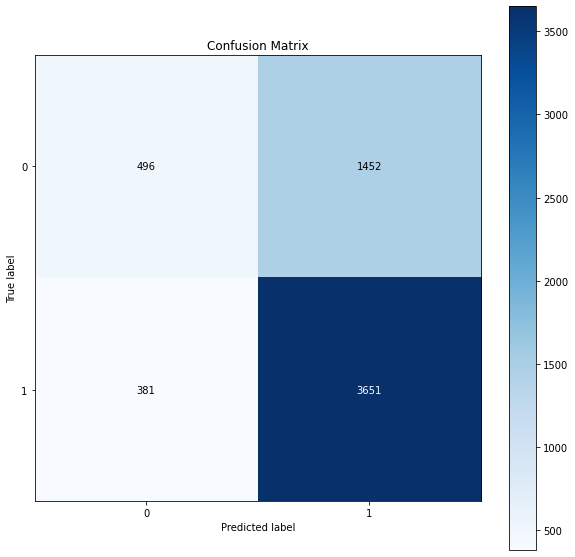

In [ ]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

lr = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
lr_scores = cross_validate(lr, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(lr_scores['fit_time']))
print("Accuracy: ",np.mean(lr_scores['test_accuracy']))
print("F1: ",np.mean(lr_scores['test_f1']))
print("Precision: ",np.mean(lr_scores['test_precision']))
print("Recall: ",np.mean(lr_scores['test_recall']))

results.loc['Accuracy-mean']['Logistic Regression'] = np.mean(lr_scores['test_accuracy'])
results.loc['F1-mean']['Logistic Regression'] = np.mean(lr_scores['test_f1'])
results.loc['Precision-mean']['Logistic Regression'] = np.mean(lr_scores['test_precision'])
results.loc['Recall-mean']['Logistic Regression'] = np.mean(lr_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['Logistic Regression'] = lr_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['Logistic Regression'] = lr_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['Logistic Regression'] = lr_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['Logistic Regression'] = lr_scores['test_recall'][i]

predictions = cross_val_predict(lr, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "LogisticRegression"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "LogisticRegression"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "LogisticRegression"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "LogisticRegression"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "LogisticRegression"] = list(fold_pred[4])[i]

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.2) RandomForest

fit_time:  0.5318846225738525
Accuracy:  0.7193979933110367
F1:  0.8098352771641293
Precision:  0.7455468498281993
Recall:  0.8864015546351558


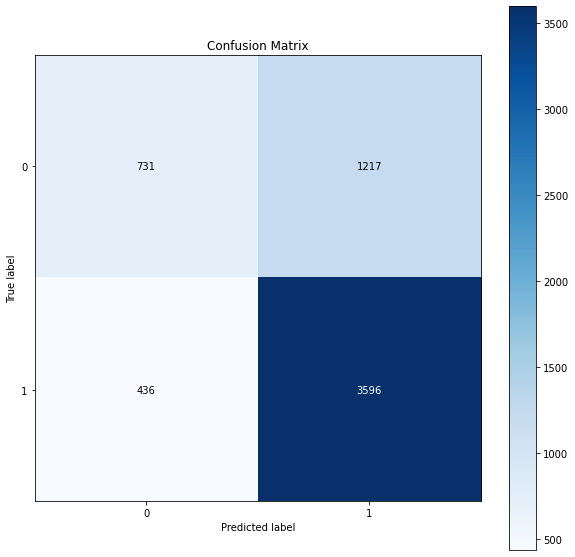

In [ ]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

rf = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}

rf_scores = cross_validate(rf, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(rf_scores['fit_time']))
print("Accuracy: ",np.mean(rf_scores['test_accuracy']))
print("F1: ",np.mean(rf_scores['test_f1']))
print("Precision: ",np.mean(rf_scores['test_precision']))
print("Recall: ",np.mean(rf_scores['test_recall']))


results.loc['Accuracy-mean']['Random Forest'] = np.mean(rf_scores['test_accuracy'])
results.loc['F1-mean']['Random Forest'] = np.mean(rf_scores['test_f1'])
results.loc['Precision-mean']['Random Forest'] = np.mean(rf_scores['test_precision'])
results.loc['Recall-mean']['Random Forest'] = np.mean(rf_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['Random Forest'] = rf_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['Random Forest'] = rf_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['Random Forest'] = rf_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['Random Forest'] = rf_scores['test_recall'][i]

predictions = cross_val_predict(rf, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "RandomForestClassifier"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "RandomForestClassifier"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "RandomForestClassifier"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "RandomForestClassifier"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "RandomForestClassifier"] = list(fold_pred[4])[i]

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.3) Gaussian Naive Bayes

fit_time:  0.13911571502685546
Accuracy:  0.5908026755852843
F1:  0.6518231619179959
Precision:  0.7646818432217617
Recall:  0.5682028528293068


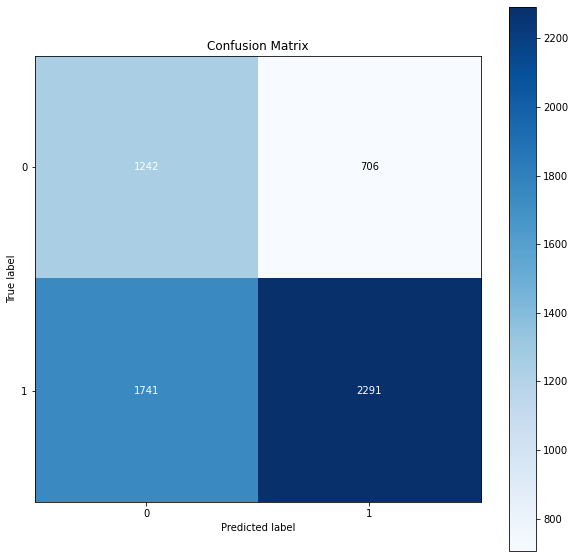

In [ ]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

gNB = GaussianNB(var_smoothing=1.0)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
gb_scores = cross_validate(gNB, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(gb_scores['fit_time']))
print("Accuracy: ",np.mean(gb_scores['test_accuracy']))
print("F1: ",np.mean(gb_scores['test_f1']))
print("Precision: ",np.mean(gb_scores['test_precision']))
print("Recall: ",np.mean(gb_scores['test_recall']))

results.loc['Accuracy-mean']['GaussianNB'] = np.mean(gb_scores['test_accuracy'])
results.loc['F1-mean']['GaussianNB'] = np.mean(gb_scores['test_f1'])
results.loc['Precision-mean']['GaussianNB'] = np.mean(gb_scores['test_precision'])
results.loc['Recall-mean']['GaussianNB'] = np.mean(gb_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['GaussianNB'] = gb_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['GaussianNB'] = gb_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['GaussianNB'] = gb_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['GaussianNB'] = gb_scores['test_recall'][i]

predictions = cross_val_predict(gNB, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "GaussianNB"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "GaussianNB"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "GaussianNB"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "GaussianNB"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "GaussianNB"] = list(fold_pred[4])[i]


fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.4) Support Vector Machine

fit_time:  4.145556020736694
Accuracy:  0.692809364548495
F1:  0.7983804935617798
Precision:  0.7161530379108016
Recall:  0.9020336940111493


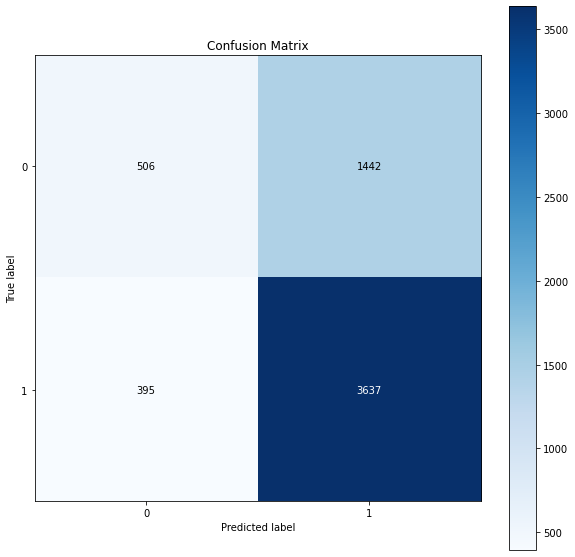

In [ ]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

svm = LinearSVC(penalty='l2',loss='squared_hinge', fit_intercept=True, dual= False, C=0.1)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
svm_scores = cross_validate(svm, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(svm_scores['fit_time']))
print("Accuracy: ",np.mean(svm_scores['test_accuracy']))
print("F1: ",np.mean(svm_scores['test_f1']))
print("Precision: ",np.mean(svm_scores['test_precision']))
print("Recall: ",np.mean(svm_scores['test_recall']))

results.loc['Accuracy-mean']['LinearSVM'] = np.mean(svm_scores['test_accuracy'])
results.loc['F1-mean']['LinearSVM'] = np.mean(svm_scores['test_f1'])
results.loc['Precision-mean']['LinearSVM'] = np.mean(svm_scores['test_precision'])
results.loc['Recall-mean']['LinearSVM'] = np.mean(svm_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['LinearSVM'] = svm_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['LinearSVM'] = svm_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['LinearSVM'] = svm_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['LinearSVM'] = svm_scores['test_recall'][i]

predictions = cross_val_predict(svm, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "LinearSVC"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "LinearSVC"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "LinearSVC"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "LinearSVC"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "LinearSVC"] = list(fold_pred[4])[i]

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.5) k-Nearest Neighbors

fit_time:  0.10367369651794434
Accuracy:  0.707190635451505
F1:  0.8043163294056977
Precision:  0.7321083126099814
Recall:  0.8923621168374737


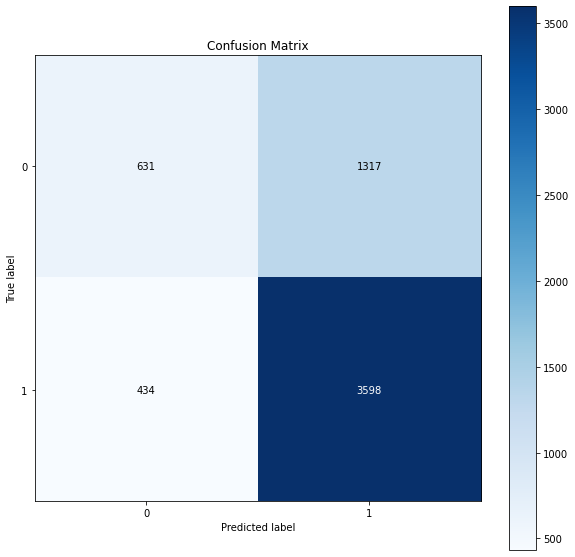

In [ ]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

knn = KNeighborsClassifier(algorithm='auto',weights='distance',p=1,n_neighbors=10, metric='minkowski', leaf_size=40)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
knn_scores = cross_validate(knn, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(knn_scores['fit_time']))
print("Accuracy: ",np.mean(knn_scores['test_accuracy']))
print("F1: ",np.mean(knn_scores['test_f1']))
print("Precision: ",np.mean(knn_scores['test_precision']))
print("Recall: ",np.mean(knn_scores['test_recall']))

results.loc['Accuracy-mean']['kNN'] = np.mean(knn_scores['test_accuracy'])
results.loc['F1-mean']['kNN'] = np.mean(knn_scores['test_f1'])
results.loc['Precision-mean']['kNN'] = np.mean(knn_scores['test_precision'])
results.loc['Recall-mean']['kNN'] = np.mean(knn_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['kNN'] = knn_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['kNN'] = knn_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['kNN'] = knn_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['kNN'] = knn_scores['test_recall'][i]

predictions = cross_val_predict(knn, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]


for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "KNeighborsClassifier"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "KNeighborsClassifier"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "KNeighborsClassifier"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "KNeighborsClassifier"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "KNeighborsClassifier"] = list(fold_pred[4])[i]


fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


###1.4.6) Decision Tree

fit_time:  0.14406585693359375
Accuracy:  0.6971571906354515
F1:  0.8017414835522059
Precision:  0.717877777832002
Recall:  0.9089825072796651


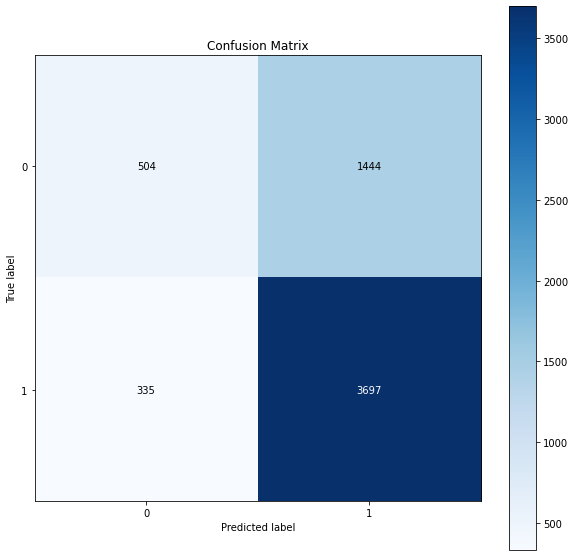

In [ ]:
X = sec_df["enc_all"].to_list()
y = sec_df['Security']
y = y.astype('int')

dt = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall': 'recall'}
dt_scores = cross_validate(dt, X, y, scoring=scoring, cv=cv)
print("fit_time: ",np.mean(dt_scores['fit_time']))
print("Accuracy: ",np.mean(dt_scores['test_accuracy']))
print("F1: ",np.mean(dt_scores['test_f1']))
print("Precision: ",np.mean(dt_scores['test_precision']))
print("Recall: ",np.mean(dt_scores['test_recall']))



results.loc['Accuracy-mean']['Decision Tree'] = np.mean(dt_scores['test_accuracy'])
results.loc['F1-mean']['Decision Tree'] = np.mean(dt_scores['test_f1'])
results.loc['Precision-mean']['Decision Tree'] = np.mean(dt_scores['test_precision'])
results.loc['Recall-mean']['Decision Tree'] = np.mean(dt_scores['test_recall'])

for i in range (0,5):
  acc = "Accuracy-fold"
  f1 = "F1-fold"
  prec = "Precision-fold"
  rec = "Recall-fold"
  results.loc[acc+str(i+1)]['Decision Tree'] = dt_scores['test_accuracy'][i]
  results.loc[f1+str(i+1)]['Decision Tree'] = dt_scores['test_f1'][i]
  results.loc[prec+str(i+1)]['Decision Tree'] = dt_scores['test_precision'][i]
  results.loc[rec+str(i+1)]['Decision Tree'] = dt_scores['test_recall'][i]

predictions = cross_val_predict(dt, X, y,cv=cv)

fold_pred = [predictions[j] for i, j in cv.split(X,y)]

for i in range(0, len(list(fold_pred[0]))):
  df_pred1.loc[i, "DecisionTreeClassifier"] = list(fold_pred[0])[i]
  df_pred2.loc[i, "DecisionTreeClassifier"] = list(fold_pred[1])[i]
  df_pred3.loc[i, "DecisionTreeClassifier"] = list(fold_pred[2])[i]
  df_pred4.loc[i, "DecisionTreeClassifier"] = list(fold_pred[3])[i]
  df_pred5.loc[i, "DecisionTreeClassifier"] = list(fold_pred[4])[i]

fig, ax = plt.subplots(figsize=(10, 10))

ax2 = skplt.metrics.plot_confusion_matrix(y, predictions,cmap=plt.cm.Blues, ax=ax)
plt.show()


##1.5) Risultati classificatore binario

In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/results.xlsx', engine='openpyxl', mode='w') as writer:
  results.to_excel(writer, sheet_name='BinaryClf Tokenizer')

results.head()

,Logistic Regression,Random Forest,GaussianNB,LinearSVM,kNN,Decision Tree
Accuracy-mean,0.693478,0.725753,0.590803,0.692809,0.707191,0.703679
F1-mean,0.799305,0.815199,0.651823,0.79838,0.804316,0.802785
Precision-mean,0.715615,0.746871,0.764682,0.716153,0.732108,0.728385
Recall-mean,0.905257,0.897562,0.568203,0.902034,0.892362,0.894836
Accuracy-fold1,0.696488,0.733278,0.579431,0.691472,0.693144,0.702341


In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/binary-clf.xlsx', engine='openpyxl', mode='w') as writer:
  df_pred1.to_excel(writer, sheet_name='Fold 1')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred2.to_excel(writer, sheet_name='Fold 2')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred3.to_excel(writer, sheet_name='Fold 3')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred4.to_excel(writer, sheet_name='Fold 4')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/binary-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred5.to_excel(writer, sheet_name='Fold 5')


#2) Classificatore Multi-label

##2.1) Caricamento del Dataset

In [ ]:
root="https://raw.githubusercontent.com/xDaryamo/NFR-Security-Extraction-Classification/master/"


#df è la variabile che contiene il dataset
df=pd.read_excel(root + "dataset.xlsx")
df=df[["Sentence","Entities", "Dependencies", "Parts of Speech", "Categories", "Security Words", "Security"]]
df.head(5)

,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,"Once completed, the electronic health record (...","['Once', 'completed', 'the', 'electronic', 'he...","['advmod', 'advcl', 'det', 'amod', 'compound',...","['ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'NOUN', ...",none,none,0
2,Canada Health Infoway's (Infoway's) Nursing Re...,"['ORG', 'ORG', 'ORG', 'ORG', 'ORG', ""'s"", 'ORG...","['compound', 'compound', 'poss', 'case', 'poss...","['PROPN', 'PROPN', 'PROPN', 'PART', 'PROPN', '...",none,none,0
3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
4,"As part of the NRG, a pan-Canadian working gro...","['As', 'part', 'of', 'the', 'ORG', 'a', 'NORP'...","['prep', 'pobj', 'prep', 'det', 'pobj', 'det',...","['ADP', 'NOUN', 'ADP', 'DET', 'PROPN', 'DET', ...",none,none,0


In [ ]:
#Per allenare il modello che si occupa di categorizzare i requisiti dobbiamo eliminare tutte le righe che non contengono un requisito di sicurezza (non hanno categorie associate)

df.drop(df[df.Security == 0.0].index, inplace=True)
df = df.reset_index()  # make sure indexes pair with number of rows
df.head()

,index,Sentence,Entities,Dependencies,Parts of Speech,Categories,Security Words,Security
0,0,The vision of healthier Canadians through inno...,"['The', 'vision', 'of', 'healthier', 'NORP', '...","['det', 'nsubjpass', 'prep', 'amod', 'pobj', '...","['DET', 'NOUN', 'ADP', 'ADJ', 'PROPN', 'ADP', ...","['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']",['access'],1
1,3,Timely access to information will help inform ...,"['Timely', 'access', 'to', 'information', 'wil...","['amod', 'nsubj', 'prep', 'pobj', 'aux', 'ROOT...","['ADJ', 'NOUN', 'ADP', 'NOUN', 'AUX', 'VERB', ...",['AVAILABILITY'],['access'],1
2,5,It was acknowledged that the EHR needs to enab...,"['It', 'was', 'acknowledged', 'that', 'the', '...","['nsubjpass', 'auxpass', 'ROOT', 'mark', 'det'...","['PRON', 'AUX', 'VERB', 'SCONJ', 'DET', 'PROPN...",['CONFIDENTIALITY'],none,1
3,14,Nursing data: Should be structured and codifie...,"['Nursing', 'data', 'Should', 'be', 'structure...","['compound', 'nsubjpass', 'aux', 'auxpass', 'R...","['NOUN', 'NOUN', 'AUX', 'AUX', 'VERB', 'CCONJ'...",['INTEGRITY'],none,1
4,17,Nursing data: Should be simple and concise to ...,"['Nursing', 'data', 'Should', 'be', 'simple', ...","['compound', 'nsubj', 'aux', 'ROOT', 'acomp', ...","['NOUN', 'NOUN', 'AUX', 'AUX', 'ADJ', 'CCONJ',...",['AVAILABILITY'],['access'],1


##2.2) Codifica delle features

In [ ]:
all_ids = encode_all(df)

cat_df=pd.DataFrame(columns=["enc_ent", "enc_dep", "enc_pos", "enc_all", "Security Words", "Categories"])



for i in range(0, len(df)):
  ent, dep, pos = str_to_list(df.iloc[i]["Entities"], df.iloc[i]["Dependencies"], df.iloc[i]["Parts of Speech"])
  cat_df.loc[i, "enc_ent"] = encode_feature(ent)
  cat_df.loc[i, "enc_dep"] = encode_feature(dep)
  cat_df.loc[i, "enc_pos"] = encode_feature(pos)
  cat_df.loc[i, "enc_all"] = all_ids[i]
  cat_df.loc[i, "Security Words"] = df.iloc[i]["Security Words"]
  cat_df.loc[i, "Categories"] = df.iloc[i]["Categories"]

cat_df.head()

,enc_ent,enc_dep,enc_pos,enc_all,Security Words,Categories
0,"[101, 1109, 4152, 1104, 100, 29029, 1194, 1003...","[101, 29046, 29015, 29041, 29069, 29068, 29041...","[101, 28999, 29051, 29064, 29059, 29018, 29064...","[101, 1109, 4152, 1104, 2332, 2852, 29029, 119...",['access'],"['CONFIDENTIALITY', 'AVAILABILITY', 'INTEGRITY']"
1,"[101, 100, 2469, 1106, 1869, 1209, 1494, 12862...","[101, 29069, 29034, 29041, 29068, 24544, 28998...","[101, 29059, 29051, 29064, 29051, 29004, 29027...","[101, 2614, 1193, 2469, 1106, 1869, 1209, 1494...",['access'],['AVAILABILITY']
2,"[101, 1135, 1108, 8646, 1115, 1103, 29050, 299...","[101, 29015, 29023, 28998, 4551, 29046, 29034,...","[101, 29026, 29004, 29027, 29024, 28999, 29018...","[101, 1135, 1108, 8646, 1115, 1103, 29050, 299...",none,['CONFIDENTIALITY']
3,"[101, 15192, 2233, 9743, 1129, 15695, 1105, 10...","[101, 7090, 29015, 24544, 29023, 28998, 14402,...","[101, 29051, 29051, 29004, 29004, 29027, 29036...","[101, 15192, 2233, 9743, 1129, 15695, 1105, 18...",none,['INTEGRITY']
4,"[101, 15192, 2233, 9743, 1129, 3014, 1105, 100...","[101, 7090, 29034, 24544, 28998, 29066, 14402,...","[101, 29051, 29051, 29004, 29004, 29059, 29036...","[101, 15192, 2233, 9743, 1129, 3014, 1105, 142...",['access'],['AVAILABILITY']


##2.3) One-hot encoding delle categorie

In [ ]:
#convertiamo le categorie in liste
cat_df['Categories'] = cat_df['Categories'].apply(lambda x: ast.literal_eval(x))


In [ ]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(cat_df['Categories'])
pd.DataFrame(y, columns=multilabel.classes_)

,ACCESS_CONTROL_IDENTITY,ACCOUNTABILITY,AVAILABILITY,CONFIDENTIALITY,INTEGRITY,OPERATIONAL,PRIVACY
0,0,0,1,1,1,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
4027,1,0,0,0,0,0,0
4028,0,1,1,1,0,0,0
4029,0,0,0,0,1,0,0
4030,0,0,0,0,1,0,0


In [ ]:
from itertools import groupby
from IPython.display import display, HTML
display(HTML(cat_df.Categories.apply(tuple).value_counts().to_frame().to_html()))

,Categories
"(CONFIDENTIALITY, ACCOUNTABILITY, INTEGRITY)",1599
"(ACCOUNTABILITY, INTEGRITY)",421
"(CONFIDENTIALITY, ACCOUNTABILITY)",331
"(CONFIDENTIALITY,)",191
"(INTEGRITY, ACCOUNTABILITY)",140
"(CONFIDENTIALITY, INTEGRITY, ACCOUNTABILITY)",135
"(OPERATIONAL,)",121
"(INTEGRITY,)",120
"(ACCOUNTABILITY,)",120
"(ACCOUNTABILITY, CONFIDENTIALITY)",82


In [ ]:
list(y[0])

[0, 0, 1, 1, 1, 0, 0]

##2.4) Creazione modelli

In [ ]:
indexes = ['Hammer-Score-mean', 'F1-mean', 'Precision-mean', 'Recall-mean', 'Hammer-Loss-mean',
           'Hammer-Score-fold1','F1-fold1','Precision-fold1','Recall-fold1','Hammer-Loss-fold1',
           'Hammer-Score-fold2','F1-fold2','Precision-fold2','Recall-fold2','Hammer-Loss-fold2',
           'Hammer-Score-fold3','F1-fold3','Precision-fold3','Recall-fold3','Hammer-Loss-fold3',
           'Hammer-Score-fold4','F1-fold4','Precision-fold4','Recall-fold4','Hammer-Loss-fold4',
           'Hammer-Score-fold5','F1-fold5','Precision-fold5','Recall-fold5','Hammer-Loss-fold5',
]

column = ['BinaryRelevance LogisticRegression','BinaryRelevance RandomForestClassifier','BinaryRelevance GaussianNB','BinaryRelevance LinearSVC','BinaryRelevance KNeighborsClassifier','BinaryRelevance DecisionTreeClassifier',
          'ClassifierChain LogisticRegression','ClassifierChain RandomForestClassifier','ClassifierChain GaussianNB','ClassifierChain LinearSVC','ClassifierChain KNeighborsClassifier','ClassifierChain DecisionTreeClassifier', 
          'LabelPowerset LogisticRegression','LabelPowerset RandomForestClassifier','LabelPowerset GaussianNB','LabelPowerset LinearSVC','LabelPowerset KNeighborsClassifier','LabelPowerset DecisionTreeClassifier'
        ]
results = pd.DataFrame(index=indexes, columns=column)
results.head()

,BinaryRelevance LogisticRegression,BinaryRelevance RandomForestClassifier,BinaryRelevance GaussianNB,BinaryRelevance LinearSVC,BinaryRelevance KNeighborsClassifier,BinaryRelevance DecisionTreeClassifier,ClassifierChain LogisticRegression,ClassifierChain RandomForestClassifier,ClassifierChain GaussianNB,ClassifierChain LinearSVC,ClassifierChain KNeighborsClassifier,ClassifierChain DecisionTreeClassifier,LabelPowerset LogisticRegression,LabelPowerset RandomForestClassifier,LabelPowerset GaussianNB,LabelPowerset LinearSVC,LabelPowerset KNeighborsClassifier,LabelPowerset DecisionTreeClassifier
Hammer-Score-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hammer-Loss-mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_pred1 = pd.DataFrame(columns=['Real Label',
                                  'BinaryRelevance LogisticRegression','BinaryRelevance RandomForestClassifier','BinaryRelevance GaussianNB','BinaryRelevance LinearSVC','BinaryRelevance KNeighborsClassifier','BinaryRelevance DecisionTreeClassifier',
                                  'ClassifierChain LogisticRegression','ClassifierChain RandomForestClassifier','ClassifierChain GaussianNB','ClassifierChain LinearSVC','ClassifierChain KNeighborsClassifier','ClassifierChain DecisionTreeClassifier', 
                                  'LabelPowerset LogisticRegression','LabelPowerset RandomForestClassifier','LabelPowerset GaussianNB','LabelPowerset LinearSVC','LabelPowerset KNeighborsClassifier','LabelPowerset DecisionTreeClassifier'])

for i in range(0, len(y)):
  df_pred1.loc[i, 'Real Label'] = list(y[i])


df_pred2 = df_pred1.copy(deep=True)
df_pred3 = df_pred1.copy(deep=True)
df_pred4 = df_pred1.copy(deep=True)
df_pred5 = df_pred1.copy(deep=True)
df_pred1.head()

,Real Label,BinaryRelevance LogisticRegression,BinaryRelevance RandomForestClassifier,BinaryRelevance GaussianNB,BinaryRelevance LinearSVC,BinaryRelevance KNeighborsClassifier,BinaryRelevance DecisionTreeClassifier,ClassifierChain LogisticRegression,ClassifierChain RandomForestClassifier,ClassifierChain GaussianNB,ClassifierChain LinearSVC,ClassifierChain KNeighborsClassifier,ClassifierChain DecisionTreeClassifier,LabelPowerset LogisticRegression,LabelPowerset RandomForestClassifier,LabelPowerset GaussianNB,LabelPowerset LinearSVC,LabelPowerset KNeighborsClassifier,LabelPowerset DecisionTreeClassifier
0,"[0, 0, 1, 1, 1, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[0, 0, 1, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[0, 0, 0, 1, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[0, 0, 0, 0, 1, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[0, 0, 1, 0, 0, 0, 0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def hamming_score(y_true, y_pred):
    return (
        (y_true & y_pred.toarray()).sum(axis=1) / (y_true | y_pred.toarray()).sum(axis=1)
    ).mean()

In [ ]:
def plot_confusion_matrix(cm):
  f, axes = plt.subplots(2, 4, figsize=(25, 15))
  axes = axes.ravel()
  for i in range(7):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g',cmap='Blues')
    disp.ax_.set_title(list(multilabel.classes_)[i])
    disp.im_.colorbar.remove()

  f.delaxes(axes[7])
  plt.subplots_adjust(wspace=0.25, hspace=0.10)
  f.colorbar(disp.im_, ax=axes)
  plt.show()


In [ ]:
def build_model(model, mlb_estimator, X, y):

  clf=mlb_estimator(model)
  kf = KFold(n_splits=5, shuffle=True)

  acc_scores = np.zeros(5)
  prec_scores = np.zeros(5)
  rec_scores = np.zeros(5)  
  f_scores = np.zeros(5)
  ham_scores = np.zeros(5)
  conf_matrix = []
  pred = pd.DataFrame(columns=['0','1','2','3','4'])
  idx = 0
  name = str(type(clf).__name__) + " " + str(type(model).__name__)
  for index, (train_indices, test_indices) in enumerate(kf.split(X, y)):
      print("Training on fold " + str(index+1) + "/5...")
      # Generate batches from indices
      X_train, X_test = X[train_indices], X[test_indices]
      y_train, y_test = y[train_indices], y[test_indices]

      clf.fit(X_train.to_list(), y_train)
      clf_pred = clf.predict(X_test.to_list())
      
      for j in range (0, len(clf_pred.toarray())):
        pred.loc[j, str(idx)] = list(clf_pred.toarray()[j])

      conf_matrix.append(multilabel_confusion_matrix(y_test, clf_pred ))
      acc_scores[idx] = hamming_score(y_test, clf_pred)
      prec_scores[idx] = precision_score(y_test, clf_pred, average='micro')
      rec_scores[idx] = recall_score(y_test, clf_pred, average='micro')
      f_scores[idx] = f1_score(y_test, clf_pred, average='micro')
      ham_scores[idx] = hamming_loss(y_test, clf_pred)
      idx+=1

  results.loc['Hammer-Score-mean'][name] = np.mean(acc_scores)
  results.loc['F1-mean'][name] = np.mean(f_scores)
  results.loc['Precision-mean'][name] = np.mean(prec_scores)
  results.loc['Recall-mean'][name] = np.mean(rec_scores)
  results.loc['Hammer-Loss-mean'][name] = np.mean(ham_scores)

  for i in range (0,5):
      acc = "Hammer-Score-fold"
      f1 = "F1-fold"
      prec = "Precision-fold"
      rec = "Recall-fold"
      ham = "Hammer-Loss-fold"
      results.loc[acc+str(i+1)][name] = acc_scores[i]
      results.loc[f1+str(i+1)][name] = f_scores[i]
      results.loc[prec+str(i+1)][name] = prec_scores[i]
      results.loc[rec+str(i+1)][name] = rec_scores[i]
      results.loc[ham+str(i+1)][name] = ham_scores[i]


  for i in range(0, len(pred)):
    df_pred1.loc[i, name] = pred.iloc[i]['0']
    df_pred2.loc[i, name] = pred.iloc[i]['1']
    df_pred3.loc[i, name] = pred.iloc[i]['2']
    df_pred4.loc[i, name] = pred.iloc[i]['3']
    df_pred5.loc[i, name] = pred.iloc[i]['4']

  return acc_scores, prec_scores, rec_scores, f_scores, ham_scores, conf_matrix

In [ ]:
X = cat_df["enc_all"]

###**2.4.1) BinaryRelevance**

####2.4.1.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6935089062514412
Precision: 0.7567410910035017
Recall Score: 0.8568616851456632
F1 Score: 0.8036343432646964
Hamming Loss: 0.14310567715052666


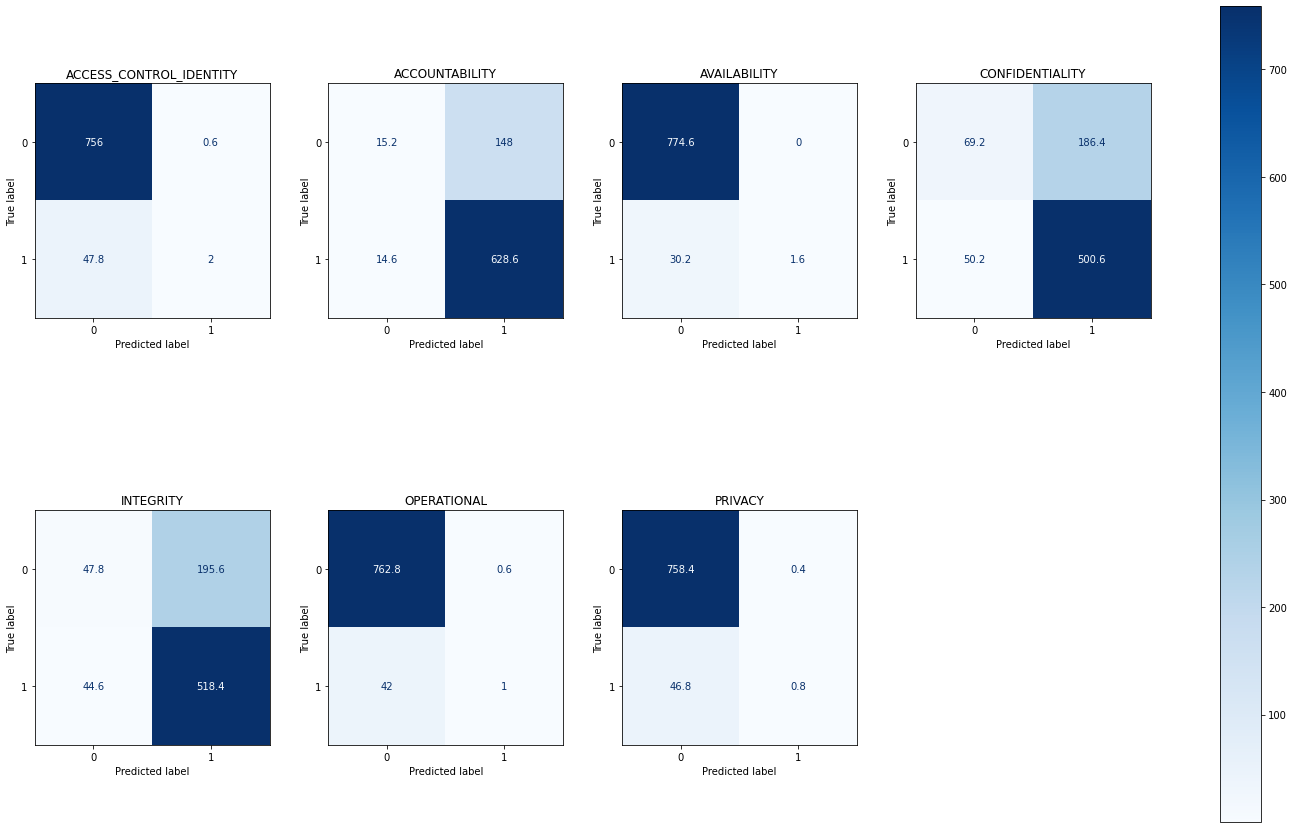

In [ ]:
model = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6848816497089671
Precision: 0.7321342157750799
Recall Score: 0.8702017386724232
F1 Score: 0.7952063206466575
Hamming Loss: 0.15316802156950857


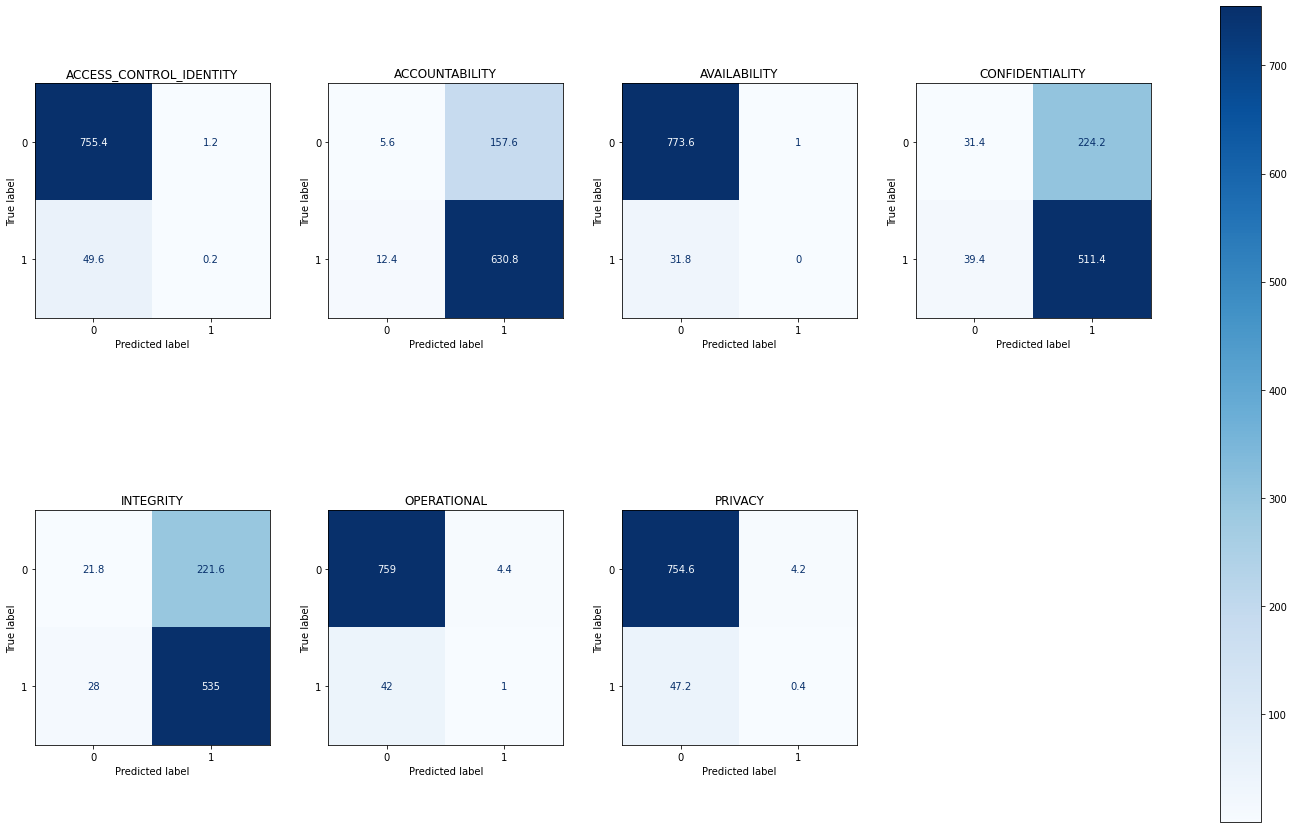

In [ ]:
model = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.596073082757937
Precision: 0.6258463355347885
Recall Score: 0.7684380387262866
F1 Score: 0.689748037379257
Hamming Loss: 0.23636423935020892


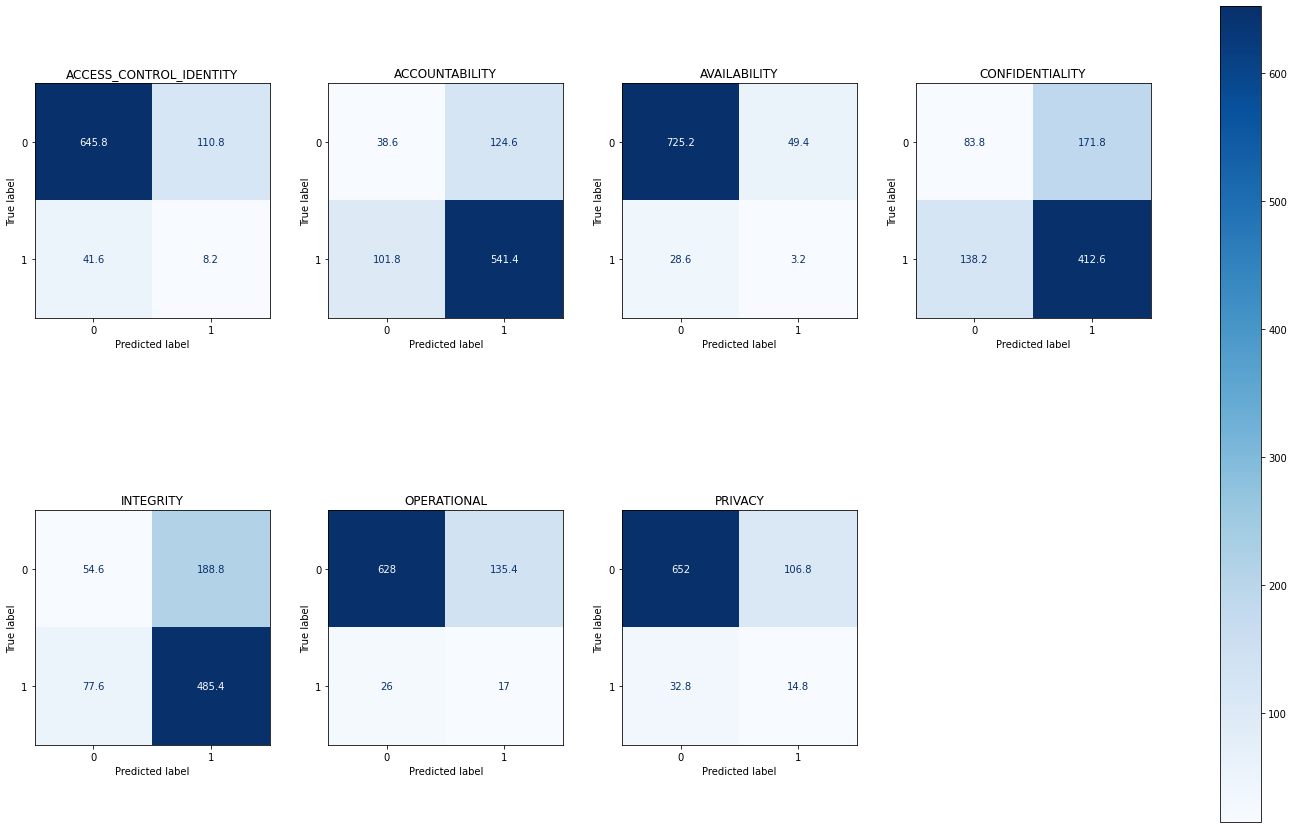

In [ ]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6711285556590749
Precision: 0.7461060336355724
Recall Score: 0.835578730218342
F1 Score: 0.788203722075459
Hamming Loss: 0.15344963227203304


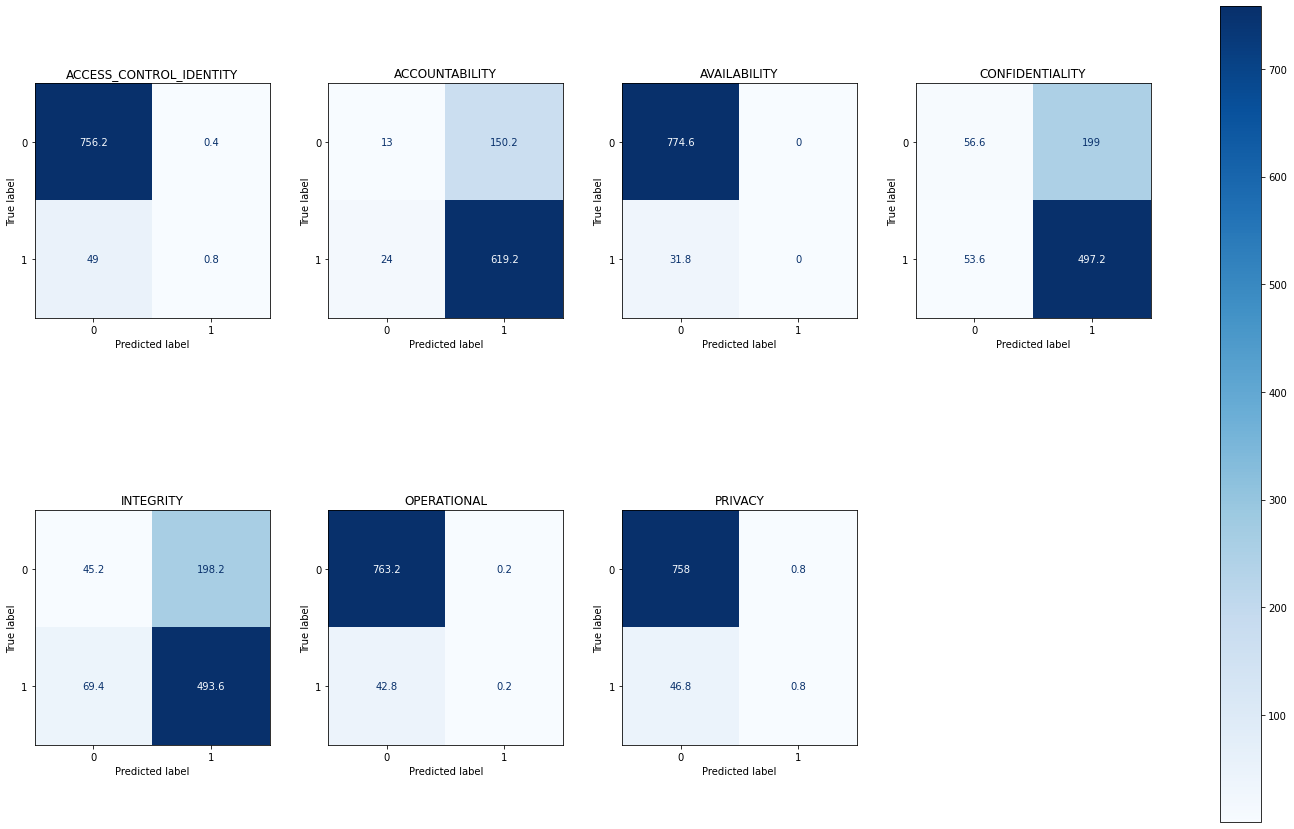

In [ ]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6869695837599663
Precision: 0.7345435001196453
Recall Score: 0.8703369102559968
F1 Score: 0.7966517599471568
Hamming Loss: 0.15181935624434723


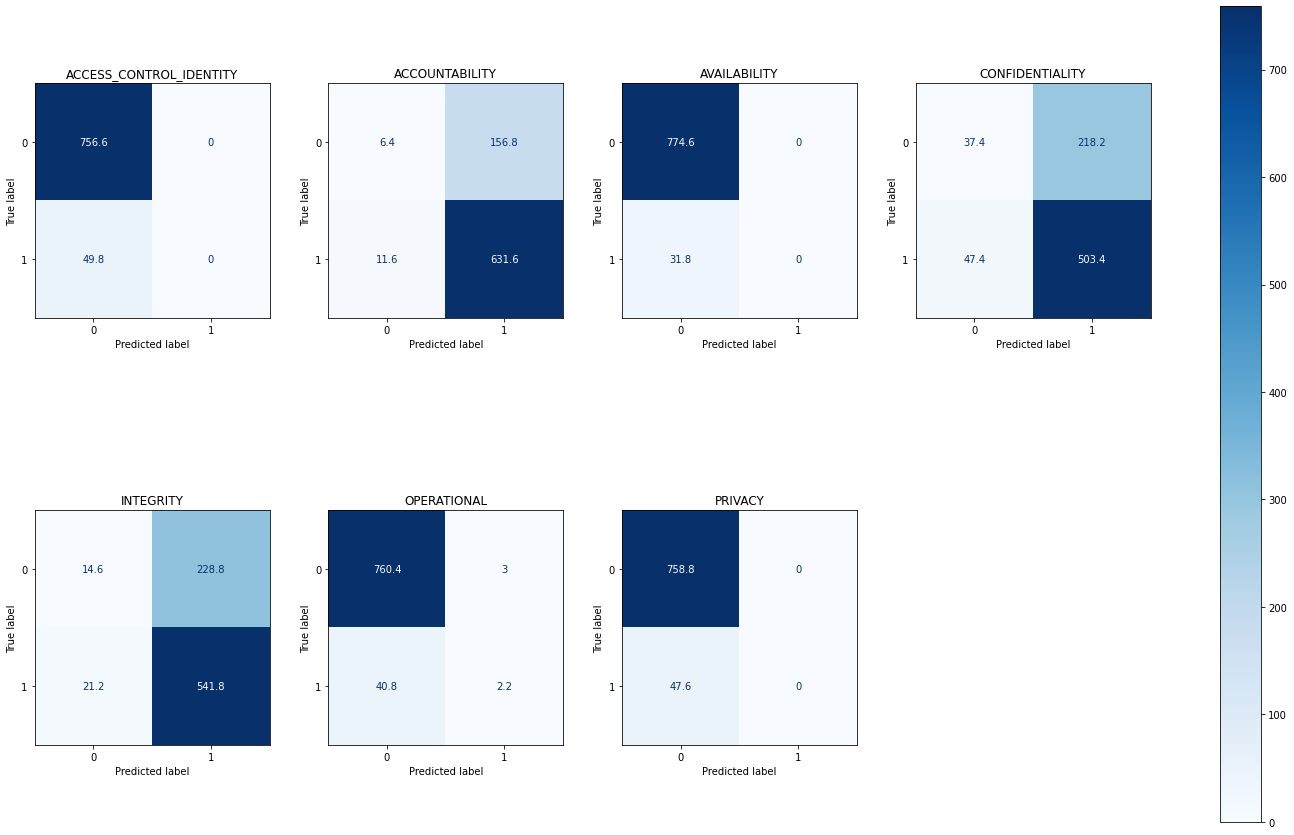

In [ ]:
model = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)

ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.1.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.683100583910633
Precision: 0.73013072740949
Recall Score: 0.8694808492478072
F1 Score: 0.7936801690030213
Hamming Loss: 0.15447403457956282


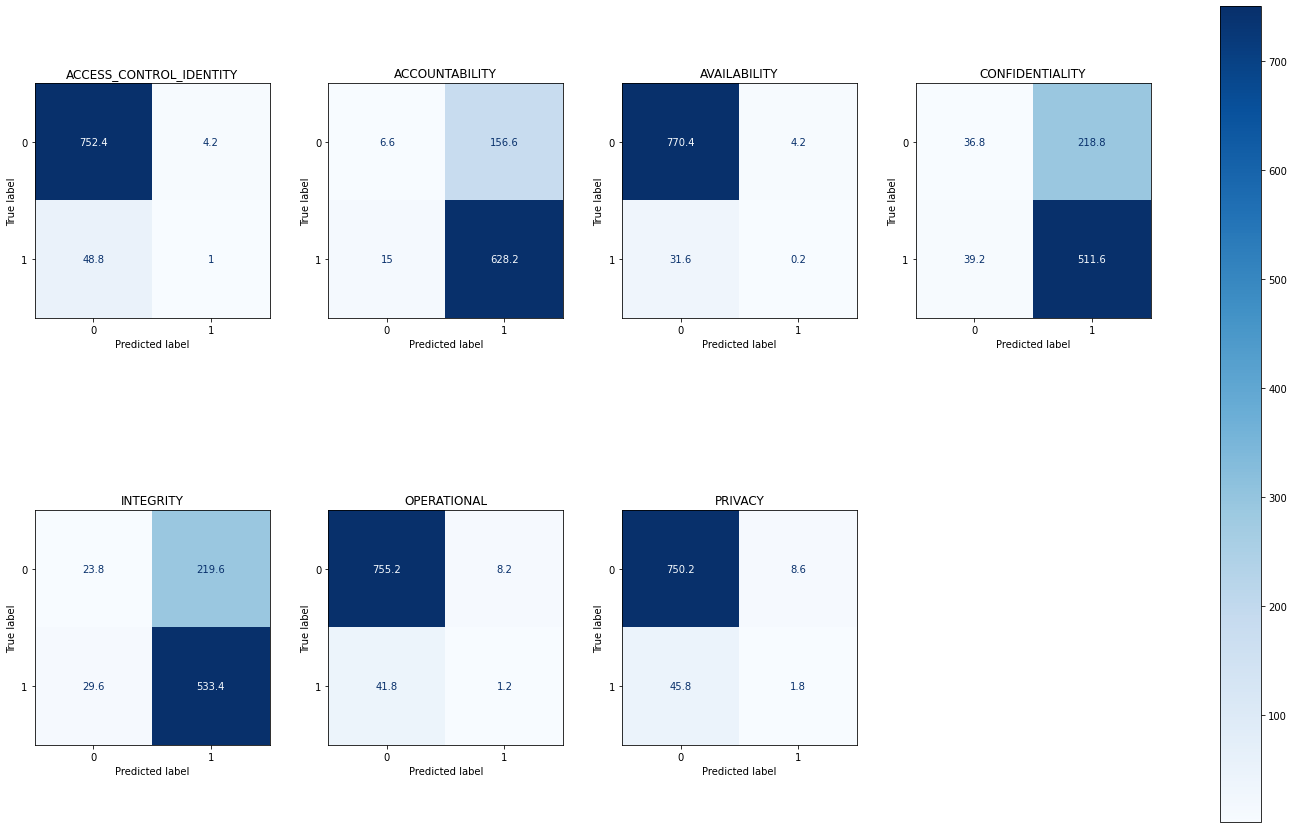

In [ ]:
model = LinearSVC(penalty='l2',loss='squared_hinge', fit_intercept=True, dual= False, C=0.1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, BinaryRelevance, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.2) ClassifierChain**

####2.4.2.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7008466704179619
Precision: 0.7509690933601016
Recall Score: 0.8711125226701718
F1 Score: 0.8065794207878543
Hamming Loss: 0.14278628993822662


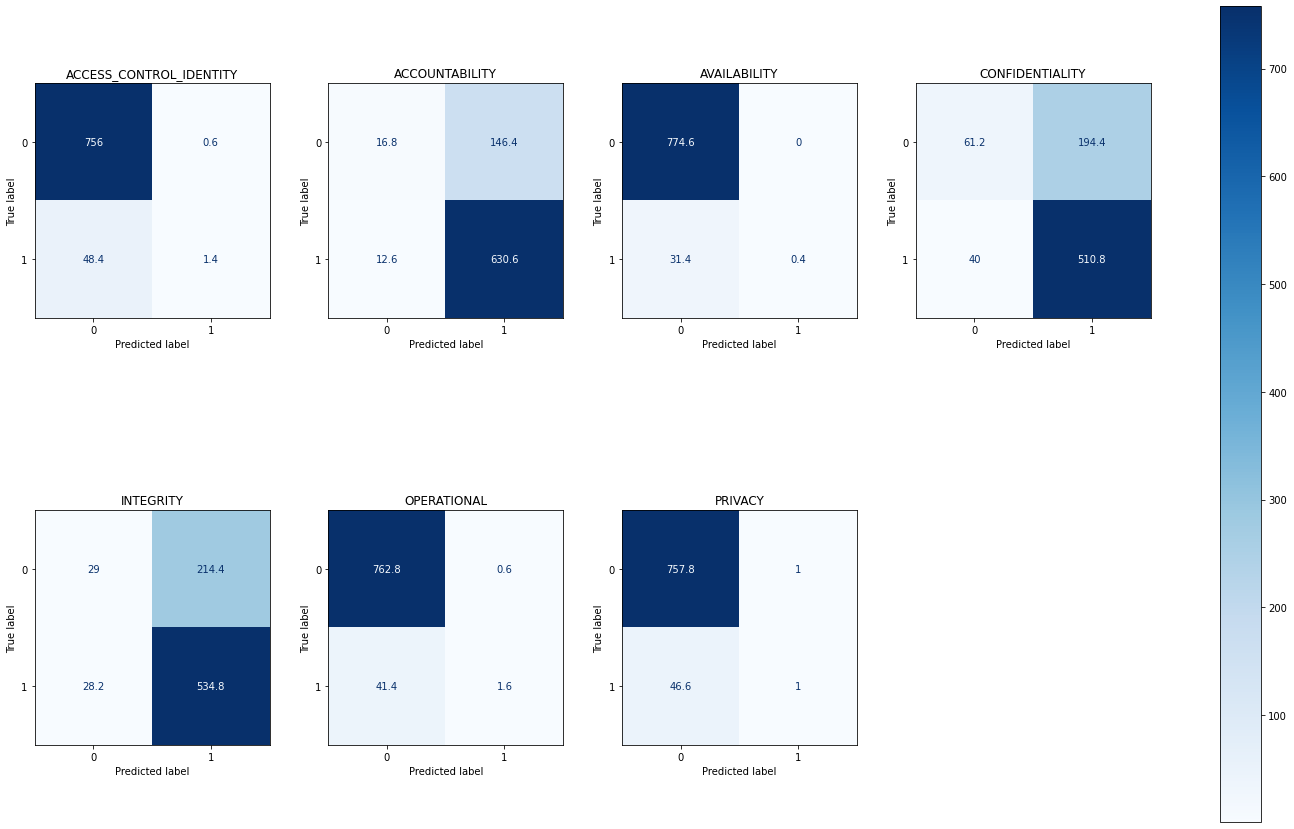

In [ ]:
model = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6807411114288439
Precision: 0.731159650895546
Recall Score: 0.8649680032568197
F1 Score: 0.7924094698021134
Hamming Loss: 0.15486827199262743


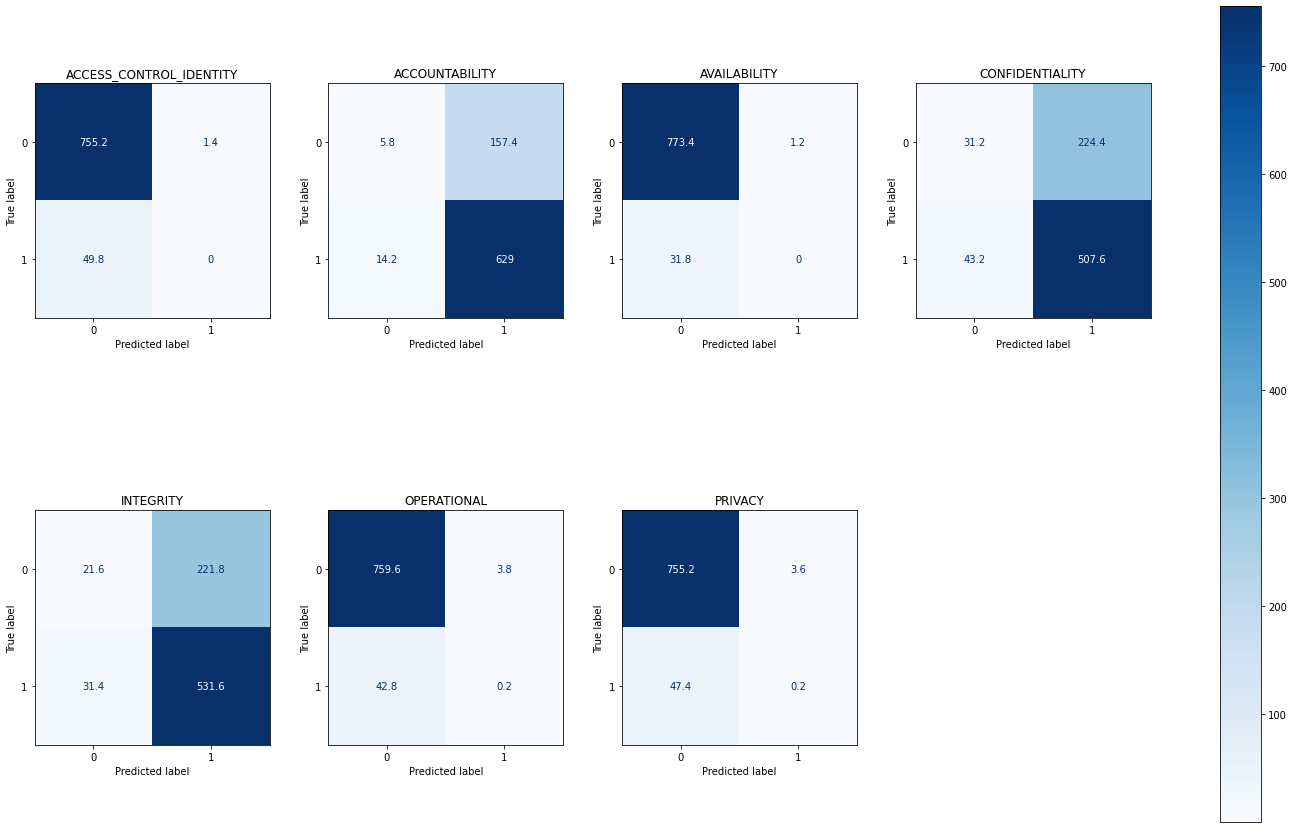

In [ ]:
model = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5931679615370705
Precision: 0.6246765152252127
Recall Score: 0.7649519127953379
F1 Score: 0.6875957735477105
Hamming Loss: 0.23756693799864442


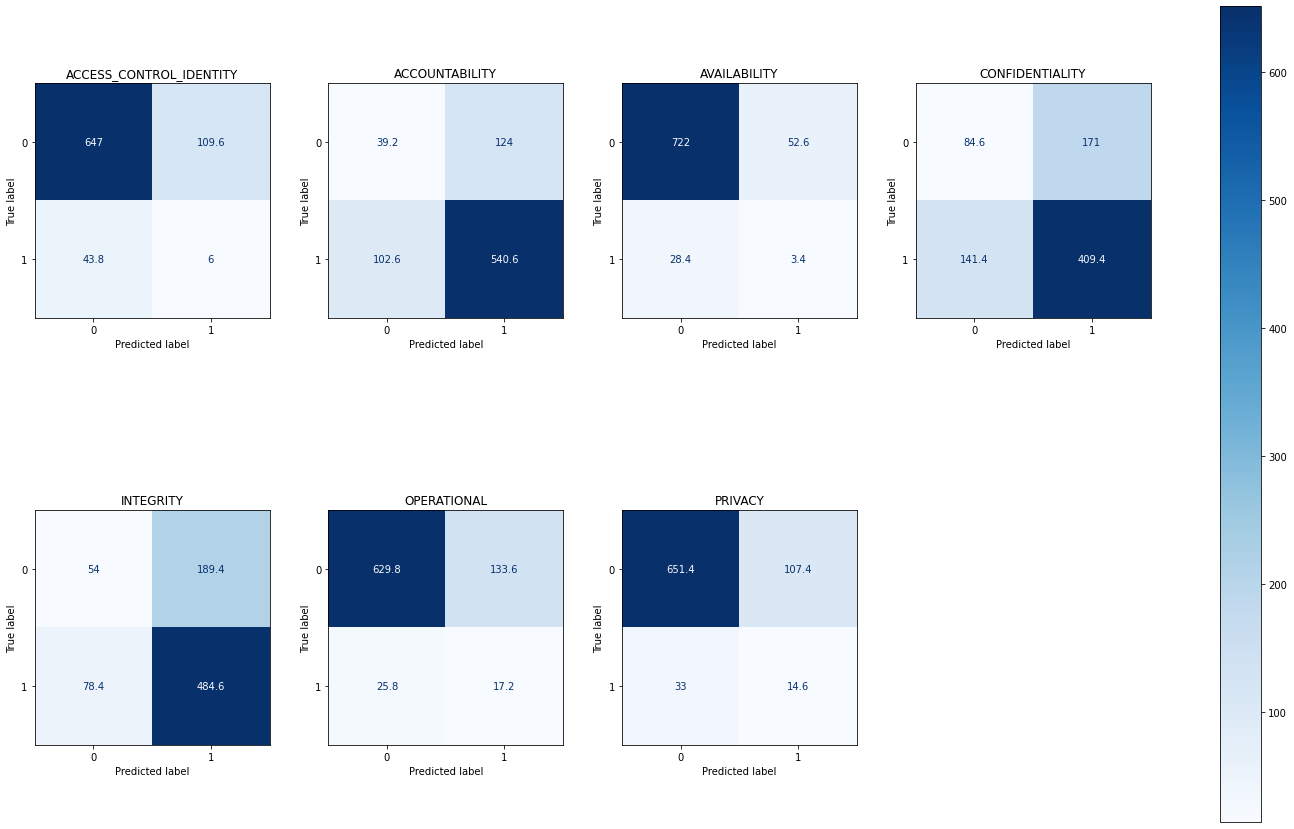

In [ ]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6734866957135814
Precision: 0.7469665588156961
Recall Score: 0.8373687875075312
F1 Score: 0.7894621145098142
Hamming Loss: 0.15260089073495958


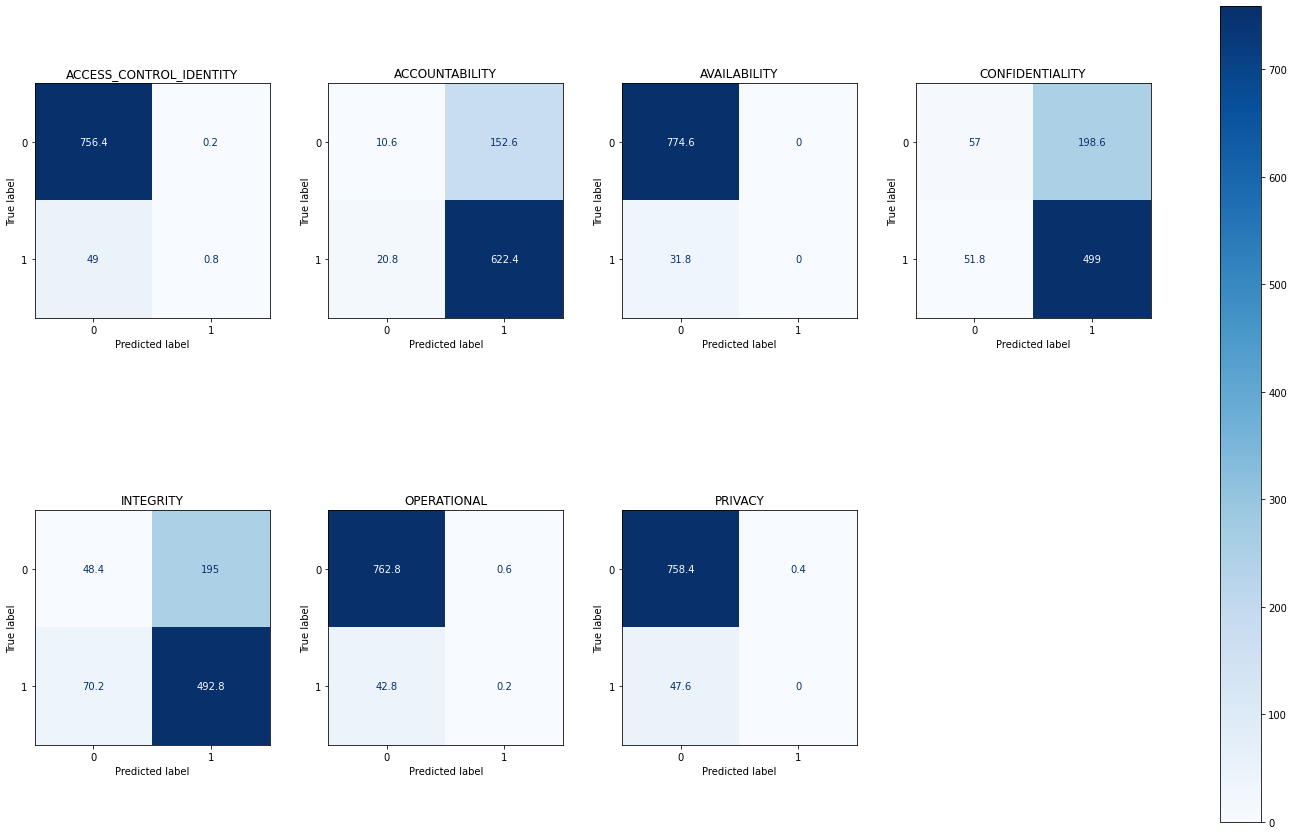

In [ ]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.689212366360106
Precision: 0.7363774969420703
Recall Score: 0.8727766218921815
F1 Score: 0.7986960123902789
Hamming Loss: 0.15036535595355596


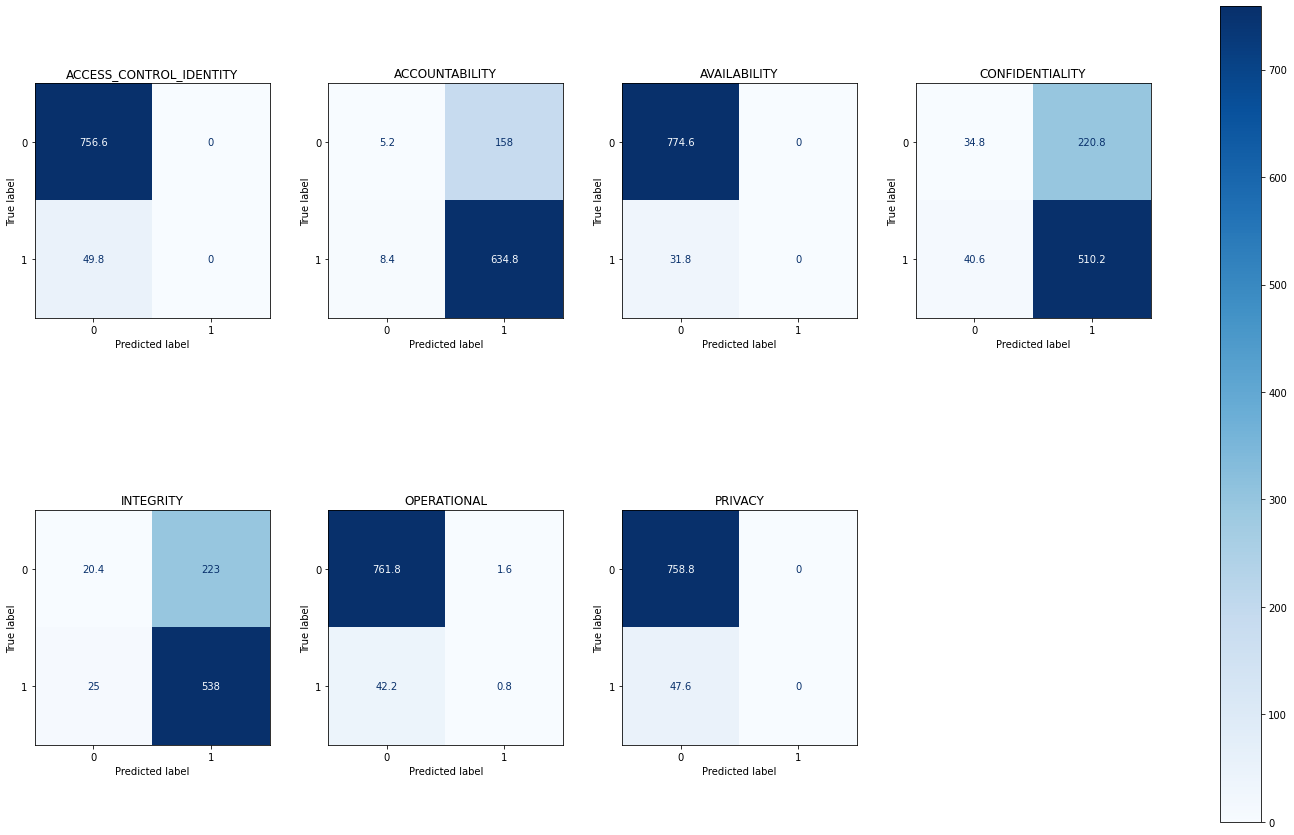

In [ ]:
model = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.2.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.682300604819492
Precision: 0.7291742828960182
Recall Score: 0.8674949887221723
F1 Score: 0.7923059908813155
Hamming Loss: 0.1553998665522829


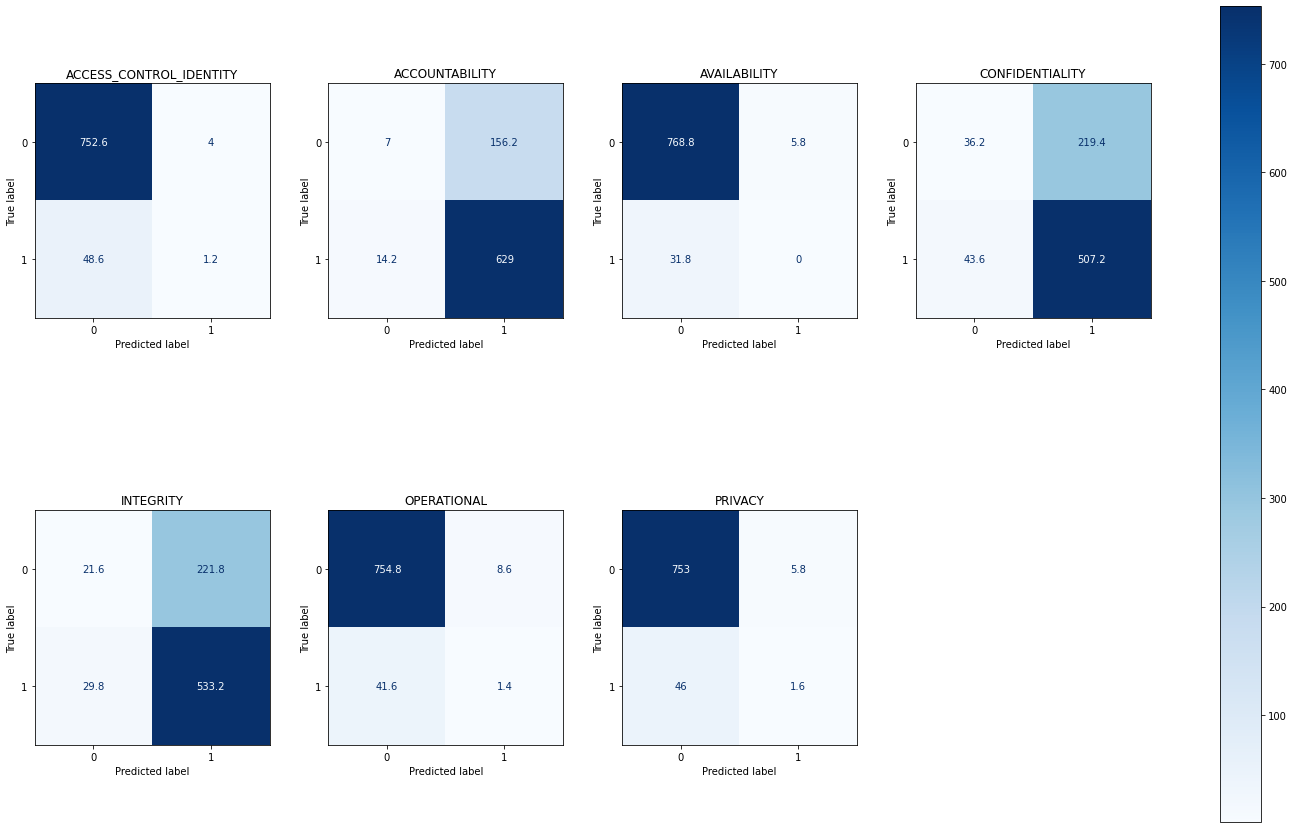

In [ ]:
model = LinearSVC(penalty='l2',loss='squared_hinge', fit_intercept=True, dual= False, C=0.1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

###**2.4.3) LabelPowerset**

####2.4.3.1) RandomForest

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7004394498920222
Precision: 0.7510268907843473
Recall Score: 0.8664693799468768
F1 Score: 0.8045770311320833
Hamming Loss: 0.14385044543336906


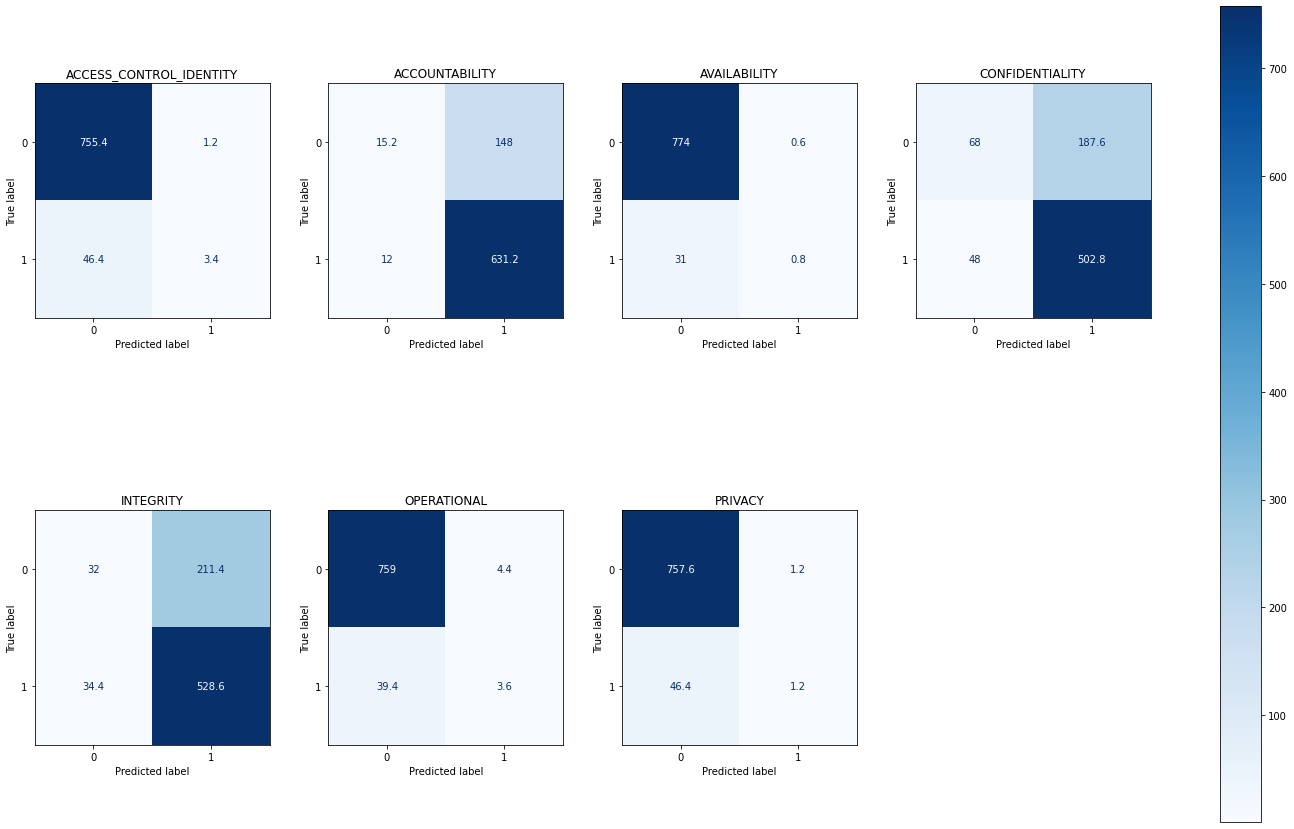

In [ ]:
model = RandomForestClassifier(n_estimators=19, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=40, bootstrap=False)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.2) LogisticRegression

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6817613612487099
Precision: 0.7272956122374035
Recall Score: 0.8689682620727972
F1 Score: 0.7918236498266548
Hamming Loss: 0.1561446348351253


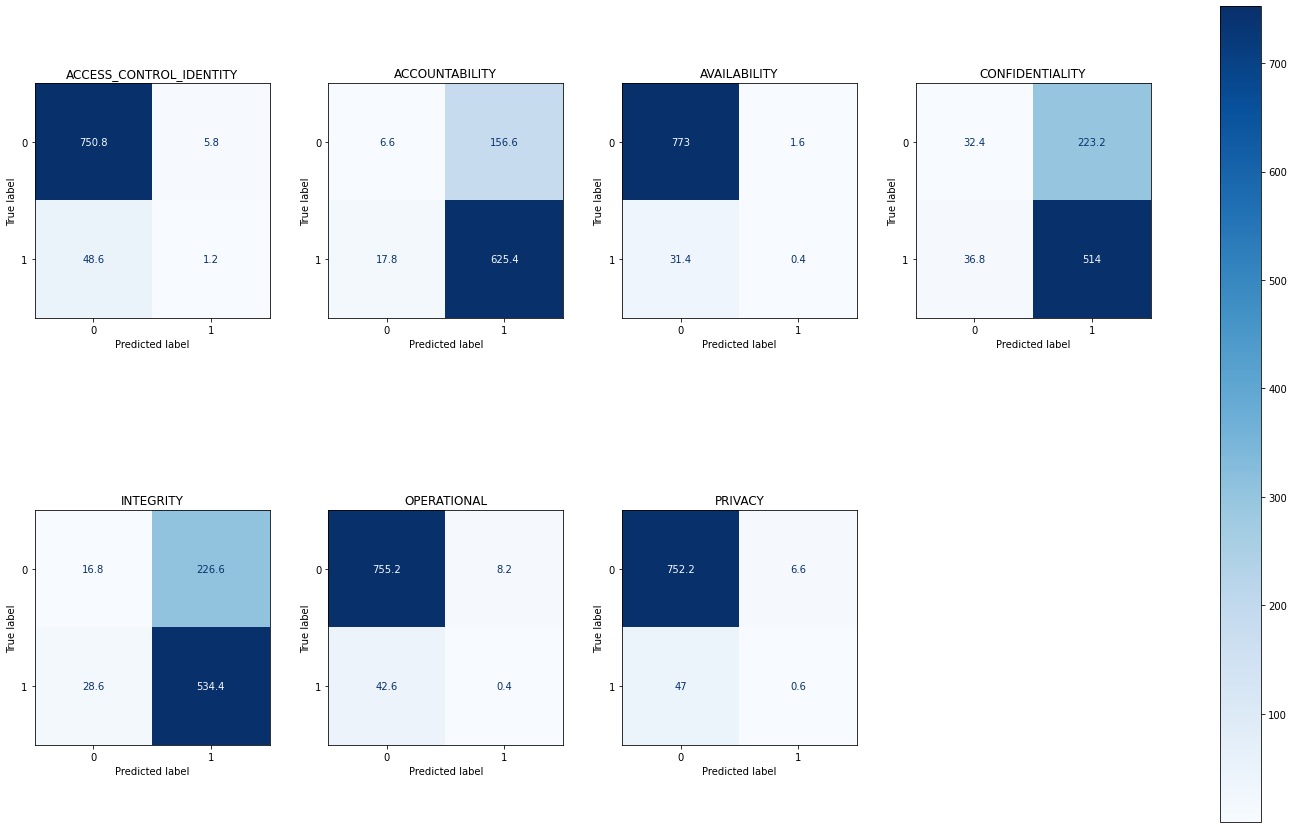

In [ ]:
model = LogisticRegression(solver='saga', penalty='l1', max_iter= 100, C=100)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.3) Gaussian Naive Bayes

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.5975131394168449
Precision: 0.6258409458461871
Recall Score: 0.7700383078486044
F1 Score: 0.690359918506265
Hamming Loss: 0.23600615317847598


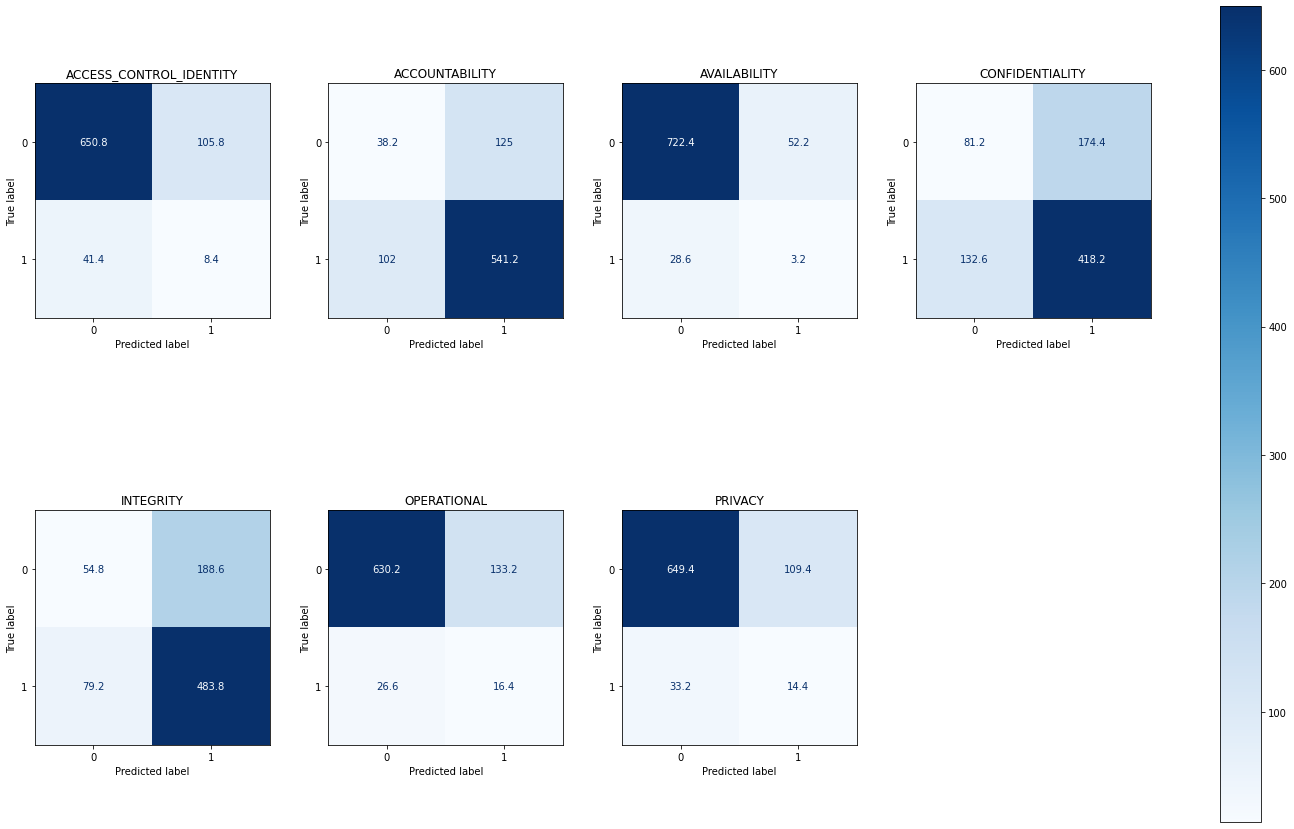

In [ ]:
model = GaussianNB(var_smoothing=1.0)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, ClassifierChain, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.4) k-NearestNeighbors

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6844037541651165
Precision: 0.7367009064029958
Recall Score: 0.8574911030756949
F1 Score: 0.7924782927598223
Hamming Loss: 0.15344849019150494


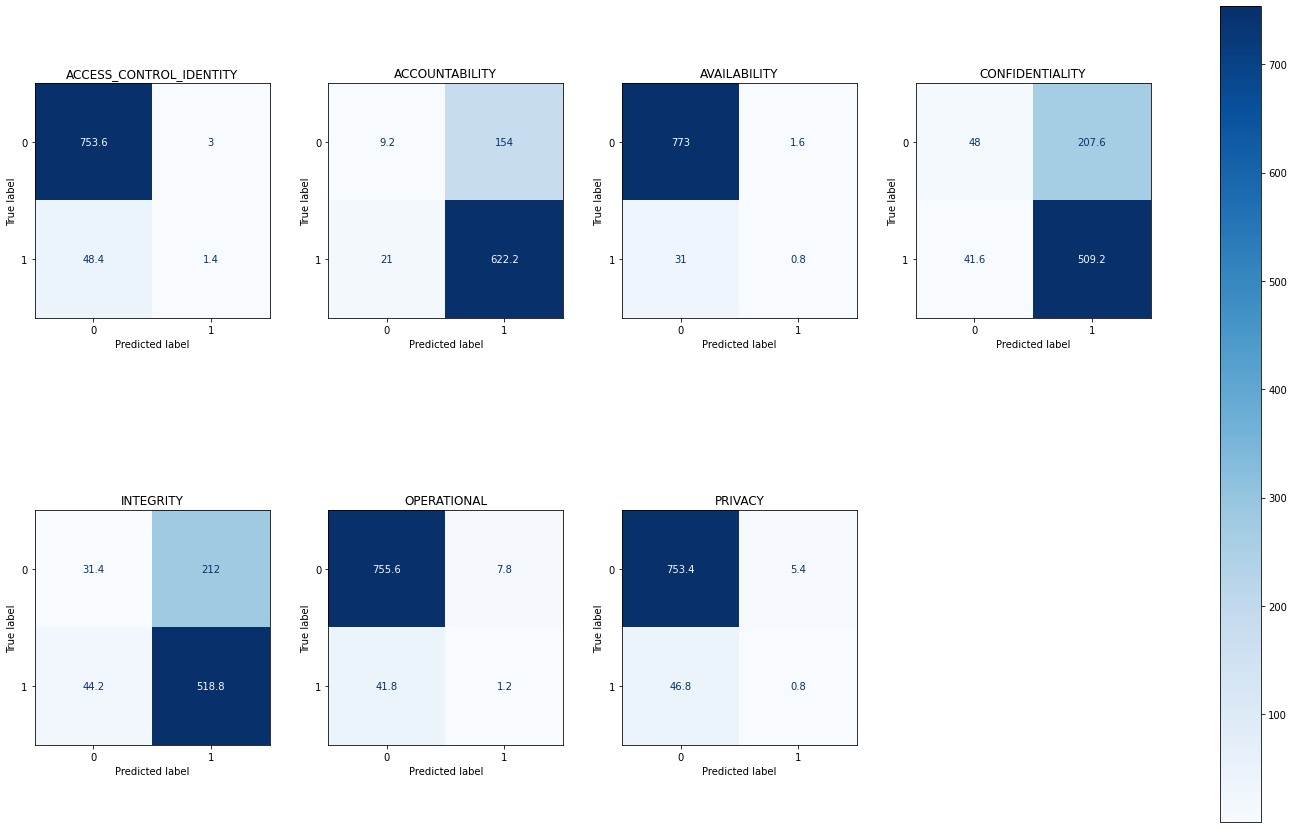

In [ ]:
model = KNeighborsClassifier(algorithm='auto', weights='distance', p=1, n_neighbors=10, metric='minkowski', leaf_size=40)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.5) Decision Tree

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.7047156190200919
Precision: 0.729076741112403
Recall Score: 0.9047287513723401
F1 Score: 0.8074541764241132
Hamming Loss: 0.1474635928887038


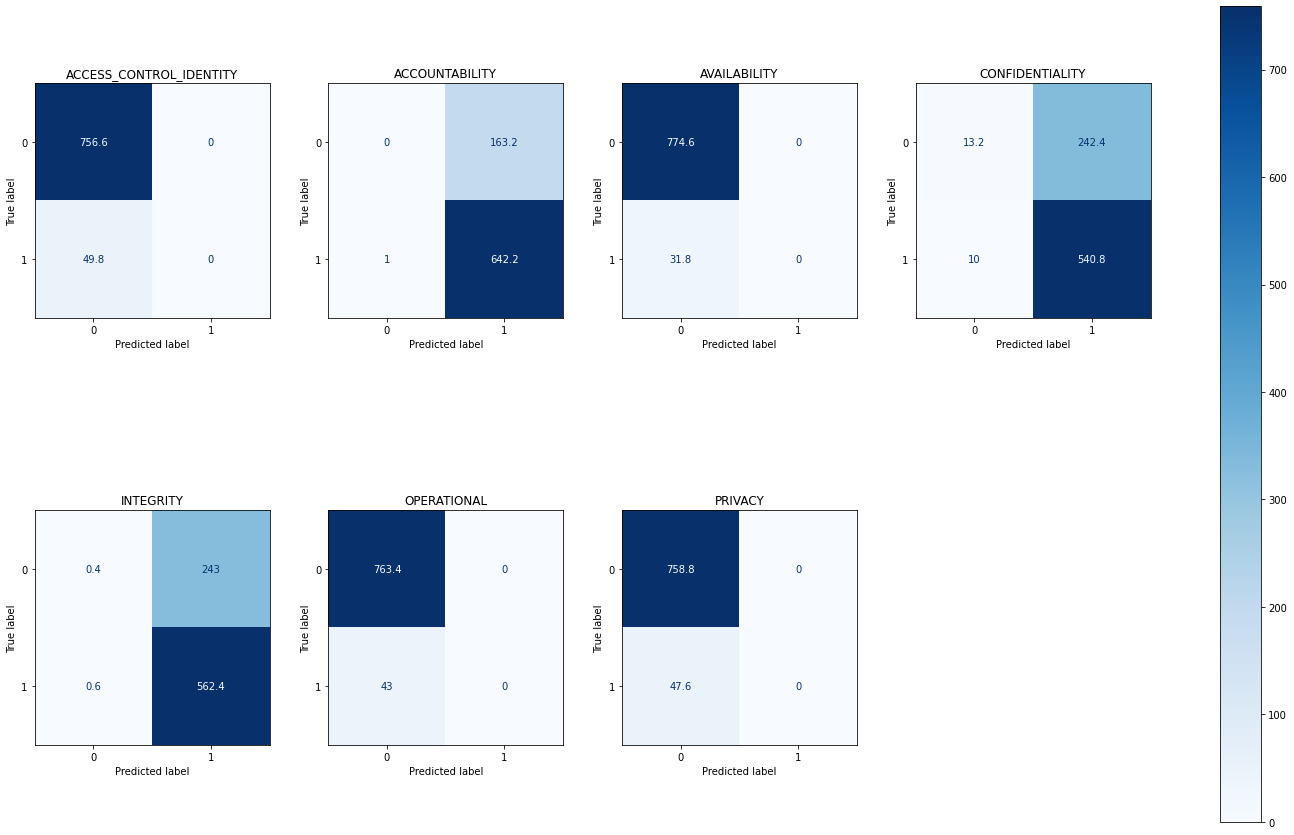

In [ ]:
model = DecisionTreeClassifier(max_features='log2',max_depth=8,criterion='gini',ccp_alpha=0.001)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

####2.4.3.6) Support Vector Machine

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
Hamming Score: 0.6077836609567033
Precision: 0.6762680986891279
Recall Score: 0.7914048241615355
F1 Score: 0.7292565696174533
Hamming Loss: 0.20078381865166853


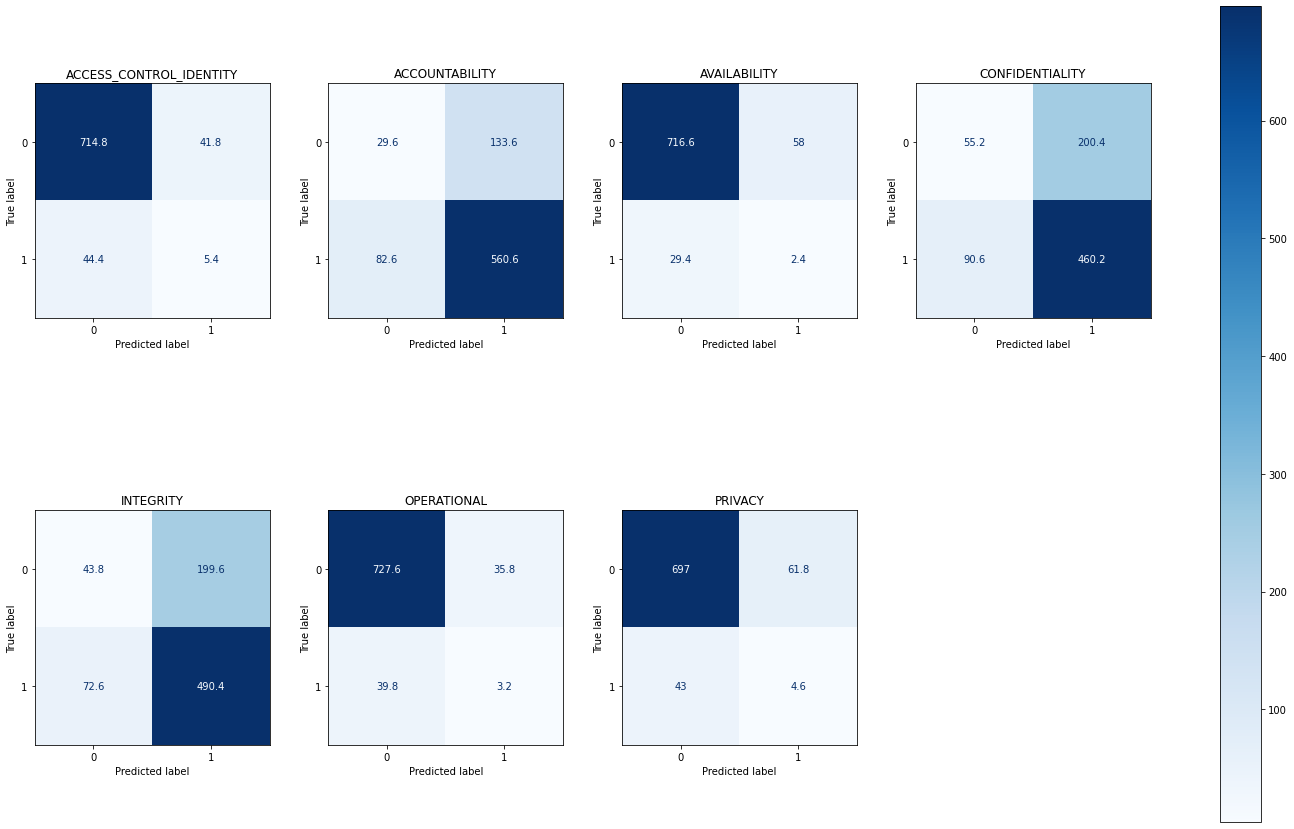

In [ ]:
model = LinearSVC(penalty='l2',loss='squared_hinge', fit_intercept=True, dual= False, C=0.1)
ham_score, prec_score, rec_score, f_score, ham_loss, conf_matrix = build_model(model, LabelPowerset, X, y)

print('='*50)
print("Hamming Score: " + str(np.mean(ham_score)))
print("Precision: " + str(np.mean(prec_score)))
print("Recall Score: " + str(np.mean(rec_score)))
print("F1 Score: " + str(np.mean(f_score)))
print("Hamming Loss: " + str(np.mean(ham_loss)))
plot_confusion_matrix(np.mean(conf_matrix, axis=0))

##2.5) Risultati classifcatore multi-label

In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/results.xlsx', engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
    results.to_excel(writer, sheet_name='MultiLabelClf Tokenizer')

results.head()

,BinaryRelevance LogisticRegression,BinaryRelevance RandomForestClassifier,BinaryRelevance GaussianNB,BinaryRelevance LinearSVC,BinaryRelevance KNeighborsClassifier,BinaryRelevance DecisionTreeClassifier,ClassifierChain LogisticRegression,ClassifierChain RandomForestClassifier,ClassifierChain GaussianNB,ClassifierChain LinearSVC,ClassifierChain KNeighborsClassifier,ClassifierChain DecisionTreeClassifier,LabelPowerset LogisticRegression,LabelPowerset RandomForestClassifier,LabelPowerset GaussianNB,LabelPowerset LinearSVC,LabelPowerset KNeighborsClassifier,LabelPowerset DecisionTreeClassifier
Hammer-Score-mean,0.683876,0.69032,0.598103,0.68274,0.672424,0.691883,0.681209,0.69607,0.593767,0.680403,0.671644,0.690694,0.682776,0.70106,NaN,0.614386,0.684494,0.704721
F1-mean,0.794681,0.801027,0.692317,0.792555,0.789026,0.801246,0.793247,0.804462,0.690137,0.790983,0.788601,0.799093,0.79275,0.805036,NaN,0.73363,0.792332,0.807516
Precision-mean,0.732627,0.755712,0.62636,0.728961,0.747,0.736289,0.731022,0.75081,0.62626,0.727938,0.746808,0.732953,0.727631,0.750905,NaN,0.678094,0.736902,0.729114
Recall-mean,0.86824,0.85217,0.773989,0.868379,0.836144,0.879069,0.867141,0.866502,0.768942,0.866038,0.83538,0.878594,0.870687,0.867643,NaN,0.799104,0.856803,0.904932
Hammer-Loss-mean,0.153344,0.144666,0.235155,0.15533,0.152814,0.149024,0.154441,0.143957,0.236179,0.156394,0.153062,0.150971,0.155579,0.143605,NaN,0.198306,0.153485,0.147425


In [ ]:
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/multilabel-clf.xlsx', engine='openpyxl', mode='w') as writer:
  df_pred1.to_excel(writer, sheet_name='Fold 1')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred2.to_excel(writer, sheet_name='Fold 2')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred3.to_excel(writer, sheet_name='Fold 3')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred4.to_excel(writer, sheet_name='Fold 4')
with pd.ExcelWriter('/content/drive/MyDrive/Security Extraction/results/predictions/tokenizer/multilabel-clf.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
  df_pred5.to_excel(writer, sheet_name='Fold 5')
